# Aprendizaje Automático 1
Tecnicatura Universitaria en Inteligencia Artificial

Materia: IA4.3

**Trabajo Práctico: Predicción de lluvia en Australia**


**Docentes:**
- Joel Spak
- Agustín Almada
- Bruno Cocitto



**Integrantes:**

| Apellido y Nombre | Legajo   |
| ----------------- | -------- |
| Aguirre, Fabián   | A-4516/1 |
| Fontela, Facundo  | F-3724/9 |

Año: 2023

Objetivo

Familiarizarse con la librería scikit-learn y las herramientas que brinda para el pre-procesamiento de datos, la implementación de modelos y la evaluación de métricas, y con TensorFlow para el entrenamiento de redes neuronales.

Dataset

El dataset se llama weatherAUS.csv y contiene información climática de Australia de los últimos diez años, incluyendo si para el día siguiente llovió o no y la cantidad de lluvia en las columnas ‘RainTomorrow’ y ‘RainfallTomorrow’. El objetivo es la predicción de estas dos variables en función del resto de las características que se consideren adecuadas.

Tiene una columna ‘Location’ que indica la ciudad y el objetivo es predecir la condición de lluvia en las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport (costa sureste). Pueden considerarse como una única ubicación. Descartar el resto de los datos.


Consignas

1- Armar grupos de hasta dos personas para la realización del trabajo práctico. Dar aviso al cuerpo docente del equipo. En caso de no tener compañero, informar al cuerpo docente.


1.   Elemento de lista
2.   Elemento de lista


2- Realizar un análisis descriptivo, que ayude a la comprensión del problema, de cada una de las variables involucradas en el problema detallando características, comportamiento y rango de variación.
Debe incluir:
 * Análisis y decisión sobre datos faltantes
 * Visualización de datos (por ejemplo histogramas, scatterplots entre variables, diagramas de caja)
 * ¿Está balanceado el dataset?
 * Codificación de variables categóricas (si se van a utilizar para predicción).
 * Matriz de correlación
 * Selección de características para la predicción.
 * Estandarización de datos.

3 - Implementar la solución del problema de regresión con regresión lineal múltiple.
 * Probar con el método LinearRegression.
 * Probar con métodos de gradiente descendiente.
 * Probar con métodos de regularización (Lasso, Ridge, Elasticnet).
 * Obtener las métricas adecuadas (entre R2 Score, MSE, RMSE, MAE, MAPE).

4 - Implementar la solución del problema de clasificación con regresión logística.
 * Obtener las métricas adecuadas (entre Accuracy, precision, recall, F1 Score, ROC-AUC, entre otras).

5 - Implementar las soluciones con una red neuronal.
 * Obtener las métricas adecuadas.

6 - Mejorar la selección de hiperparámetros.
 * Probar validación cruzada.

7 - MLOps (a definir).
8 - scribir una conclusión del trabajo



#Desarrollo

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf

In [2]:
!pip install optuna
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.0 MB/s eta 0:00:00


In [3]:
import shap
import optuna
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [4]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import recall_score

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss

Descarga del conjunto de datos

In [6]:
!pip install gdown

import gdown

url = 'https://drive.google.com/uc?id=13cbr0Jghx2oXZuSprzJhWeHEwDcgxxBT'
output = 'weatherAUS.csv'
gdown.download(url, output, quiet=False)
warnings.simplefilter('ignore')

Downloading...
From: https://drive.google.com/uc?id=13cbr0Jghx2oXZuSprzJhWeHEwDcgxxBT
To: /content/weatherAUS.csv
100%|██████████| 17.2M/17.2M [00:00<00:00, 50.4MB/s]


In [7]:
### Carga datos de dataset
### Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
### tras observar los datos del día de hoy, el objetivo es predecir las variables target:
###                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
###                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',',engine='python')


##Análisis exploratorio

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        145412 non-null  int64  
 1   Date              145412 non-null  object 
 2   Location          145412 non-null  object 
 3   MinTemp           143928 non-null  float64
 4   MaxTemp           144159 non-null  float64
 5   Rainfall          142152 non-null  float64
 6   Evaporation       82658 non-null   float64
 7   Sunshine          75616 non-null   float64
 8   WindGustDir       135096 non-null  object 
 9   WindGustSpeed     135159 non-null  float64
 10  WindDir9am        134850 non-null  object 
 11  WindDir3pm        141186 non-null  object 
 12  WindSpeed9am      143645 non-null  float64
 13  WindSpeed3pm      142351 non-null  float64
 14  Humidity9am       142759 non-null  float64
 15  Humidity3pm       140907 non-null  float64
 16  Pressure9am       13

In [9]:
df.rename(columns = {'Unnamed: 0': 'id'}, inplace = True)
df.head()

id        Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0   0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1   1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2   2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3   3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4   4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed  ... Humidity3pm Pressure9am  Pressure3pm  \
0           W           44.0  ...        22.0      1007.7       1007.1   
1         WNW           44.0  ...        25.0      1010.6       1007.8   
2         WSW           46.0  ...        30.0      1007.6       1008.7   
3          NE           24.0  ...        16.0      1017.6       1012.8   
4           W           41.0  ...        33.0      1010.8       1006.0   

   Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \
0       8.0       NaN     16.9     21.8         No            No   
1       NaN       NaN     17.2     24.3         No            No   
2       NaN       2.0     21.0     23.2         No            No   
3       NaN       NaN     18.1     26.5         No            No   
4       7.0       8.0     17.8     29.7         No            No   

   RainfallTomorrow  
0               0.0  
1               0.0  
2               0.0  
3               1.0  
4               0.2  

[5 rows x 25 columns]

In [10]:
# Definimos array con las ubicaciones necesarias
ubicaciones = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']

# Borramos los registros correspondientes a las ubicaciones que no importan
df = df[df['Location'].isin(ubicaciones)]

df['Location'].unique()

array(['Sydney', 'SydneyAirport', 'Canberra', 'MelbourneAirport',
       'Melbourne'], dtype=object)

In [11]:
#Cantidad de Na por ciudad
na_counts = df.groupby('Location').apply(lambda x: x.isna().sum())
print(na_counts)

                  id  Date  Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
Location                                                                        
Canberra           0     0         0        6        3        18         1603   
Melbourne          0     0         0      480      481       758            3   
MelbourneAirport   0     0         0        0        0         0            3   
Sydney             0     0         0        4        2         7           51   
SydneyAirport      0     0         0        1        0         4           46   

                  Sunshine  WindGustDir  WindGustSpeed  ...  Humidity3pm  \
Location                                                ...                
Canberra              1914          339            337  ...           12   
Melbourne                1           14             14  ...          487   
MelbourneAirport         1           15             15  ...            9   
Sydney                  16         1038           10

In [12]:
ciudades = df.groupby('Location')

# Contamos los valores (incluyendo NaN) por cada ciudad
resultado = ciudades.size().reset_index(name='Total')

print(resultado)

           Location  Total
0          Canberra   3435
1         Melbourne   3192
2  MelbourneAirport   3008
3            Sydney   3343
4     SydneyAirport   3008


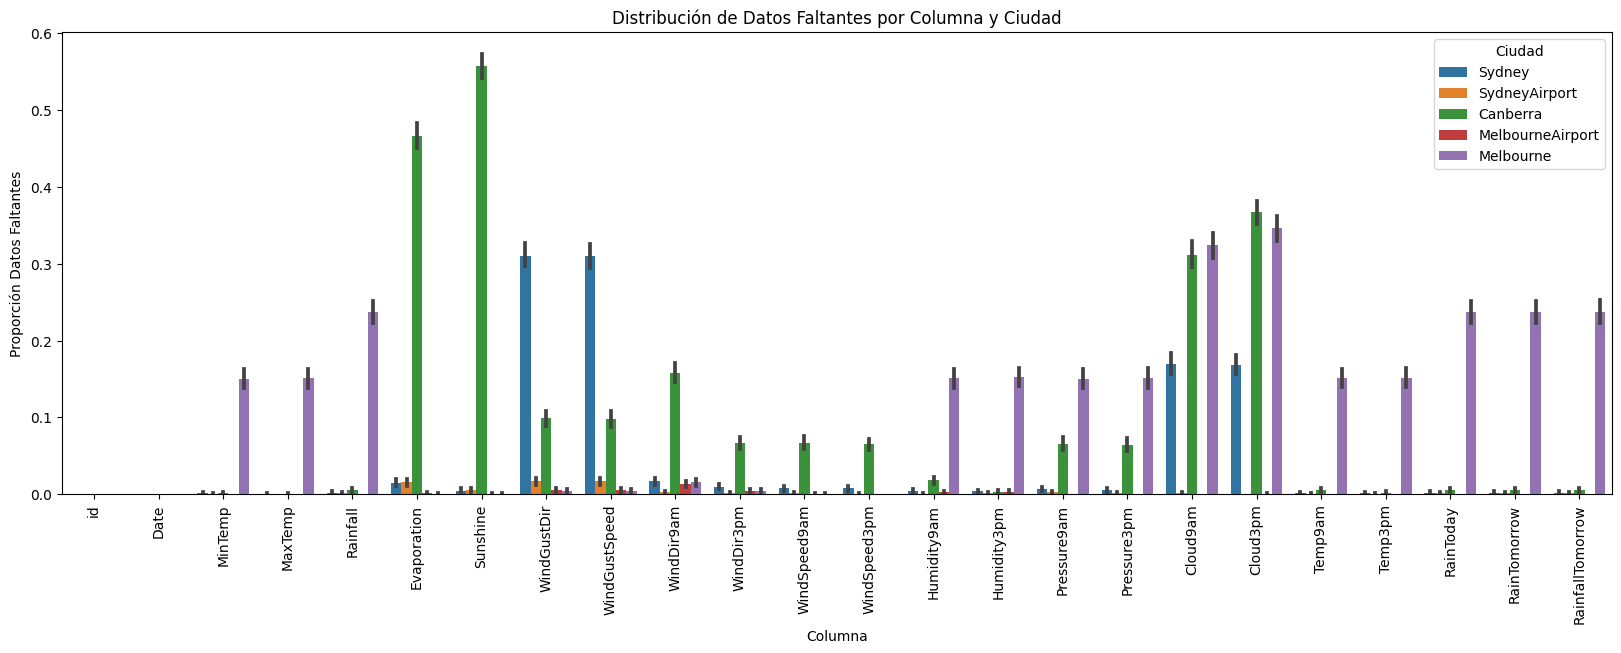

In [13]:
# Creamos un DataFrame para la información de datos faltantes
missing_data = df.isna()

# Reorganizamos los datos para facilitar la visualización
missing_data['Location'] = df['Location']
missing_data = missing_data.melt(id_vars='Location', var_name='Columna', value_name='Cantidad de Datos Faltantes')

# Creamos el gráfico de barras
plt.figure(figsize=(20, 6))
sns.barplot(data=missing_data, x='Columna', y='Cantidad de Datos Faltantes', hue='Location')
plt.xlabel('Columna')
plt.ylabel('Proporción Datos Faltantes')
plt.title('Distribución de Datos Faltantes por Columna y Ciudad')
plt.legend(title='Ciudad')
plt.xticks(rotation=90)

plt.show()

In [14]:
# Borrar filas que no contienen informacion
df.dropna(how='all', inplace=True)
df.isna().sum().sort_values(ascending=True)

id                     0
Date                   0
Location               0
WindSpeed3pm         249
WindSpeed9am         261
WindDir3pm           290
MaxTemp              486
MinTemp              491
Temp3pm              496
Temp9am              505
Humidity3pm          525
Humidity9am          570
WindDir9am           695
Pressure3pm          726
Pressure9am          735
RainToday            787
Rainfall             787
RainTomorrow         787
RainfallTomorrow     787
WindGustSpeed       1455
WindGustDir         1457
Evaporation         1706
Sunshine            1948
Cloud9am            2677
Cloud3pm            2932
dtype: int64

In [15]:
df_numeric = df.select_dtypes(include=['number'])
df_numeric.head()

id  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
30167  30176     19.5     22.4      15.6          6.2       0.0   
30168  30177     19.5     25.6       6.0          3.4       2.7   
30169  30178     21.6     24.5       6.6          2.4       0.1   
30170  30179     20.2     22.8      18.8          2.2       0.0   
30171  30180     19.7     25.7      77.4          NaN       0.0   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
30167            NaN          17.0          20.0         92.0         84.0   
30168            NaN           9.0          13.0         83.0         73.0   
30169            NaN          17.0           2.0         88.0         86.0   
30170            NaN          22.0          20.0         83.0         90.0   
30171            NaN          11.0           6.0         88.0         74.0   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
30167       1017.6       1017.4       8.0       8.0     20.7     20.9   
30168       1017.9       1016.4       7.0       7.0     22.4     24.8   
30169       1016.7       1015.6       7.0       8.0     23.5     23.0   
30170       1014.2       1011.8       8.0       8.0     21.4     20.9   
30171       1008.3       1004.8       8.0       8.0     22.5     25.5   

       RainfallTomorrow  
30167               6.0  
30168               6.6  
30169              18.8  
30170              77.4  
30171               1.6

In [16]:
# Borramos la columna location, se trabajara con todas las ciudades como una ubicacion unica

df.drop(['Location'], axis=1, inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15986 entries, 30167 to 70370
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                15986 non-null  int64  
 1   Date              15986 non-null  object 
 2   MinTemp           15495 non-null  float64
 3   MaxTemp           15500 non-null  float64
 4   Rainfall          15199 non-null  float64
 5   Evaporation       14280 non-null  float64
 6   Sunshine          14038 non-null  float64
 7   WindGustDir       14529 non-null  object 
 8   WindGustSpeed     14531 non-null  float64
 9   WindDir9am        15291 non-null  object 
 10  WindDir3pm        15696 non-null  object 
 11  WindSpeed9am      15725 non-null  float64
 12  WindSpeed3pm      15737 non-null  float64
 13  Humidity9am       15416 non-null  float64
 14  Humidity3pm       15461 non-null  float64
 15  Pressure9am       15251 non-null  float64
 16  Pressure3pm       15260 non-null  fl

In [18]:
# Borramos las filas que no tienen informacion referente a la lluvia (variables target)

df = df[df['RainToday'].notna()]
df = df[df['RainTomorrow'].notna()]
df = df[df['RainfallTomorrow'].notna()]

# Borramos los registros que no tienen valores en variables categoricas, dado que es dificil inferir dicho valor.
df = df[df['WindGustDir'].notna()]
df = df[df['WindDir3pm'].notna()]
df = df[df['WindDir9am'].notna()]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13166 entries, 31147 to 70370
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                13166 non-null  int64  
 1   Date              13166 non-null  object 
 2   MinTemp           13166 non-null  float64
 3   MaxTemp           13166 non-null  float64
 4   Rainfall          13166 non-null  float64
 5   Evaporation       11679 non-null  float64
 6   Sunshine          11660 non-null  float64
 7   WindGustDir       13166 non-null  object 
 8   WindGustSpeed     13166 non-null  float64
 9   WindDir9am        13166 non-null  object 
 10  WindDir3pm        13166 non-null  object 
 11  WindSpeed9am      13166 non-null  float64
 12  WindSpeed3pm      13166 non-null  float64
 13  Humidity9am       13116 non-null  float64
 14  Humidity3pm       13131 non-null  float64
 15  Pressure9am       13147 non-null  float64
 16  Pressure3pm       13148 non-null  fl

In [20]:
# Calcular la proporción de valores NaN por columna
nan_proportion = df.isna().mean().sort_values()

# El resultado será una Serie que muestra la proporción de NaN por columna
print(nan_proportion)

id                  0.000000
RainToday           0.000000
WindSpeed3pm        0.000000
RainTomorrow        0.000000
WindDir3pm          0.000000
WindDir9am          0.000000
WindGustSpeed       0.000000
WindSpeed9am        0.000000
Rainfall            0.000000
MaxTemp             0.000000
MinTemp             0.000000
Date                0.000000
WindGustDir         0.000000
RainfallTomorrow    0.000000
Temp3pm             0.000608
Temp9am             0.000911
Pressure3pm         0.001367
Pressure9am         0.001443
Humidity3pm         0.002658
Humidity9am         0.003798
Evaporation         0.112942
Sunshine            0.114386
Cloud9am            0.117727
Cloud3pm            0.131703
dtype: float64


In [21]:
# Calcular la cantidad de NaN y el total de filas por columna
nan_count = df.isna().sum().sort_values()
total_rows = df.shape[0]

# El resultado será una Serie que muestra la cantidad de NaN y el total de filas por columna
print("Cantidad de NaN por columna:")
print(nan_count)
print("\nTotal de filas por columna:")
print(total_rows)

Cantidad de NaN por columna:
id                     0
RainToday              0
WindSpeed3pm           0
RainTomorrow           0
WindDir3pm             0
WindDir9am             0
WindGustSpeed          0
WindSpeed9am           0
Rainfall               0
MaxTemp                0
MinTemp                0
Date                   0
WindGustDir            0
RainfallTomorrow       0
Temp3pm                8
Temp9am               12
Pressure3pm           18
Pressure9am           19
Humidity3pm           35
Humidity9am           50
Evaporation         1487
Sunshine            1506
Cloud9am            1550
Cloud3pm            1734
dtype: int64

Total de filas por columna:
13166


In [22]:
## Columnas
## Numericas: 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
##            'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainfallTomorrow'
## Date
## Categoricas: 'RainToday', 'RainTomorrow', 'WindDir3pm', 'WindDir9am', 'WindGustDir'

df.columns

Index(['id', 'Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [23]:
## La fecha se encuentra en formato string, se hace cast a date

df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")

In [24]:
# Se agrega una variable categorica de estaciones
# Se supone a priori que esta informacion sera util para el modelo
# Estaciones:

seasons = { 1: "verano", 2: "otoño", 3: "invierno", 4: "primavera"}
def get_season(date):
  year = date.year
  start_dates = [(year, 3, 20), (year, 6, 20), (year, 9, 21), (year, 12, 21)]

  for i in range(len(start_dates)):
    if date < pd.Timestamp(*start_dates[i]):
      return seasons.get(i+1)
  return seasons.get(1)

df["Season"] = df["Date"].apply(get_season)

In [25]:
# Reemplazamos las variables categoricas de direccion del viento utilizando solo 4 direcciones (N, S, E, W)
# Con el objetivo de hacer mas simple el dataset y el modelo

def get_wind(wind_dir):
  return wind_dir[0:1]

df["WindGustDir"] = df["WindGustDir"].apply(get_wind)
df["WindDir3pm"] = df["WindDir3pm"].apply(get_wind)
df["WindDir9am"] = df["WindDir9am"].apply(get_wind)

In [26]:
df.WindGustDir.unique()

array(['E', 'N', 'W', 'S'], dtype=object)

In [27]:
# Se crean variables dummy para las columnas categoricas, de modo tal de poder utilizarlas en el modelo

df = pd.get_dummies(df)
df.head()

id       Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
31147  31156 2010-10-08     13.8     19.5       0.0          4.6       9.5   
31150  31159 2010-10-11     16.5     21.1       1.2          6.2       6.6   
31151  31160 2010-10-12     16.4     21.8       1.0          6.0       5.9   
31152  31161 2010-10-13     16.7     23.9       0.4          7.0       2.8   
31153  31162 2010-10-14     17.8     28.9       2.0          4.0      10.8   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm  ...  WindDir3pm_S  \
31147           35.0           4.0          19.0  ...             0   
31150           56.0          26.0          20.0  ...             0   
31151           50.0          13.0          28.0  ...             0   
31152           39.0           7.0          19.0  ...             0   
31153           41.0          22.0          17.0  ...             0   

       WindDir3pm_W  RainToday_No  RainToday_Yes  RainTomorrow_No  \
31147             0             1              0                1   
31150             0             0              1                1   
31151             0             1              0                1   
31152             0             1              0                0   
31153             0             0              1                1   

       RainTomorrow_Yes  Season_invierno  Season_otoño  Season_primavera  \
31147                 0                0             0                 1   
31150                 0                0             0                 1   
31151                 0                0             0                 1   
31152                 1                0             0                 1   
31153                 0                0             0                 1   

       Season_verano  
31147              0  
31150              0  
31151              0  
31152              0  
31153              0  

[5 rows x 39 columns]

# **Analisis Descriptivo**

In [28]:
df.describe()

id       MinTemp       MaxTemp      Rainfall   Evaporation  \
count  13166.000000  13166.000000  13166.000000  13166.000000  11679.000000   
mean   49709.536533     11.680845     21.825429      2.305180      4.901276   
std    14836.259066      5.726222      6.085430      7.433264      3.065325   
min    31156.000000     -7.600000      4.100000      0.000000      0.000000   
25%    34567.250000      7.900000     17.200000      0.000000      2.600000   
50%    47405.500000     11.600000     21.400000      0.000000      4.400000   
75%    66118.750000     15.800000     25.900000      0.800000      6.800000   
max    70391.000000     30.500000     46.800000    119.400000     23.800000   

           Sunshine  WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am  \
count  11660.000000   13166.000000  13166.000000  13166.000000  13116.000000   
mean       6.911878      44.669604     17.088334     22.183807     68.406145   
std        3.843028      14.863702     10.180730      9.556974     15.525477   
min        0.000000      11.000000      2.000000      2.000000     11.000000   
25%        3.800000      33.000000      9.000000     15.000000     58.000000   
50%        7.600000      43.000000     15.000000     22.000000     69.000000   
75%       10.000000      54.000000     22.000000     28.000000     80.000000   
max       13.900000     122.000000     69.000000     76.000000    100.000000   

       ...  WindDir3pm_S  WindDir3pm_W  RainToday_No  RainToday_Yes  \
count  ...  13166.000000  13166.000000  13166.000000   13166.000000   
mean   ...      0.358575      0.164970      0.764925       0.235075   
std    ...      0.479600      0.371168      0.424062       0.424062   
min    ...      0.000000      0.000000      0.000000       0.000000   
25%    ...      0.000000      0.000000      1.000000       0.000000   
50%    ...      0.000000      0.000000      1.000000       0.000000   
75%    ...      1.000000      0.000000      1.000000       0.000000   
max    ...      1.000000      1.000000      1.000000       1.000000   

       RainTomorrow_No  RainTomorrow_Yes  Season_invierno  Season_otoño  \
count     13166.000000      13166.000000     13166.000000  13166.000000   
mean          0.770849          0.229151         0.248443      0.256038   
std           0.420302          0.420302         0.432126      0.436460   
min           0.000000          0.000000         0.000000      0.000000   
25%           1.000000          0.000000         0.000000      0.000000   
50%           1.000000          0.000000         0.000000      0.000000   
75%           1.000000          0.000000         0.000000      1.000000   
max           1.000000          1.000000         1.000000      1.000000   

       Season_primavera  Season_verano  
count      13166.000000   13166.000000  
mean           0.246392       0.249127  
std            0.430926       0.432524  
min            0.000000       0.000000  
25%            0.000000       0.000000  
50%            0.000000       0.000000  
75%            0.000000       0.000000  
max            1.000000       1.000000  

[8 rows x 38 columns]

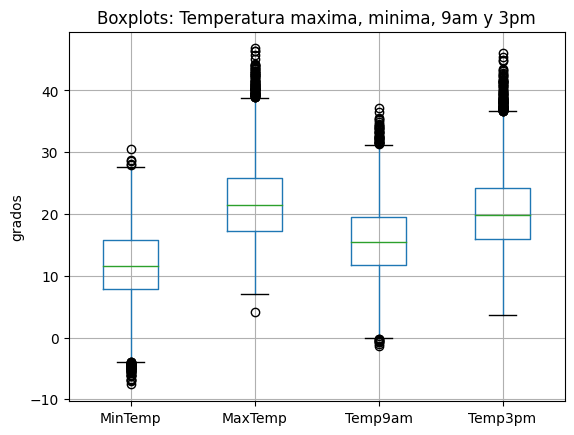

In [29]:
df.boxplot(column=['MinTemp', 'MaxTemp', "Temp9am", "Temp3pm"])
plt.ylabel("grados")
plt.title("Boxplots: Temperatura maxima, minima, 9am y 3pm")
plt.show()

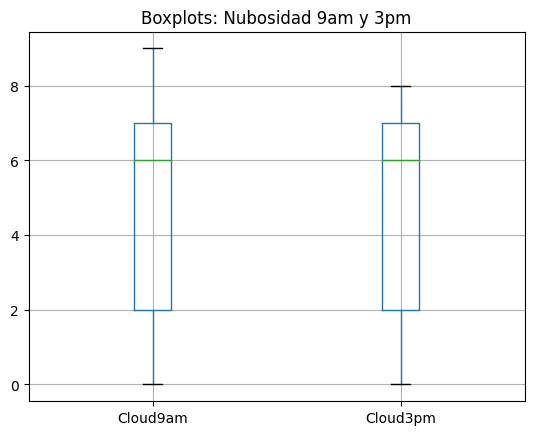

In [30]:
df.boxplot(column=['Cloud9am', 'Cloud3pm'])
plt.ylabel("")
plt.title("Boxplots: Nubosidad 9am y 3pm")
plt.show()

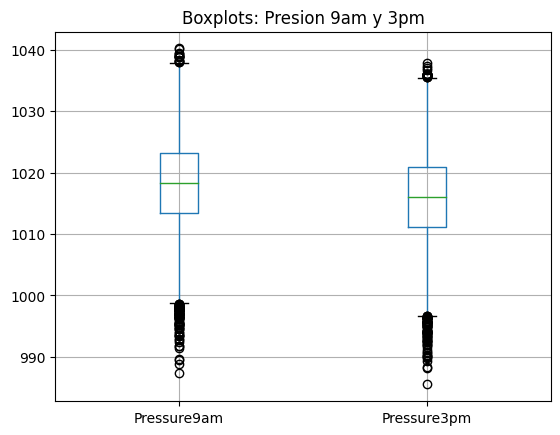

In [31]:
df.boxplot(column=['Pressure9am', 'Pressure3pm'])
plt.ylabel("")
plt.title("Boxplots: Presion 9am y 3pm")
plt.show()

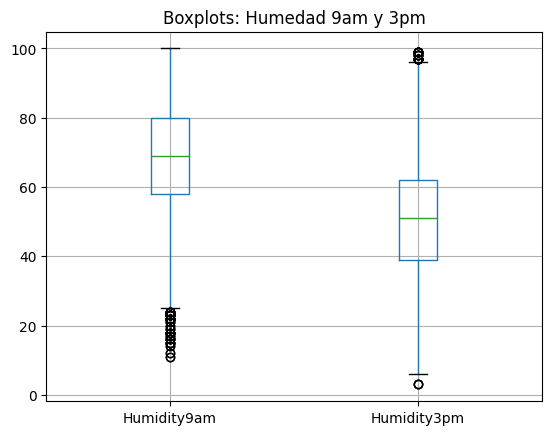

In [32]:
df.boxplot(column=['Humidity9am', 'Humidity3pm'])
plt.ylabel("")
plt.title("Boxplots: Humedad 9am y 3pm")
plt.show()

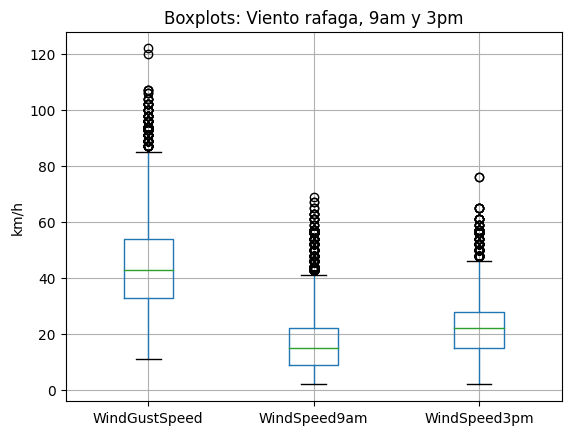

In [33]:
df.boxplot(column=['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'])
plt.ylabel("km/h")
plt.title("Boxplots: Viento rafaga, 9am y 3pm")
plt.show()

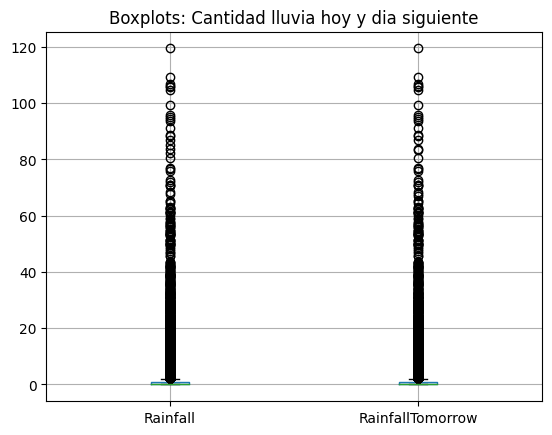

In [34]:
df.boxplot(column=['Rainfall', 'RainfallTomorrow'])
plt.ylabel("")
plt.title("Boxplots: Cantidad lluvia hoy y dia siguiente")
plt.show()

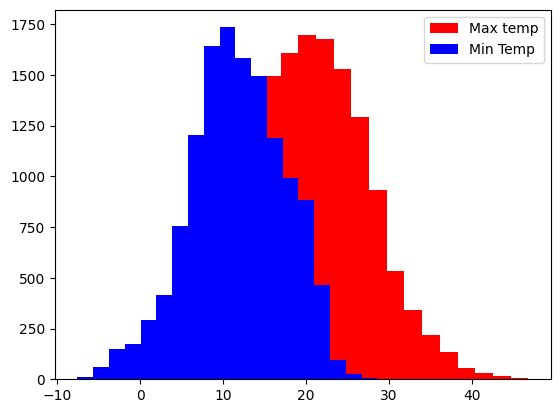

In [35]:
plt.hist(df["MaxTemp"], color='r', label='Max temp', bins=20)
plt.hist(df.MinTemp, color='b', label='Min Temp', bins=20)

plt.legend();

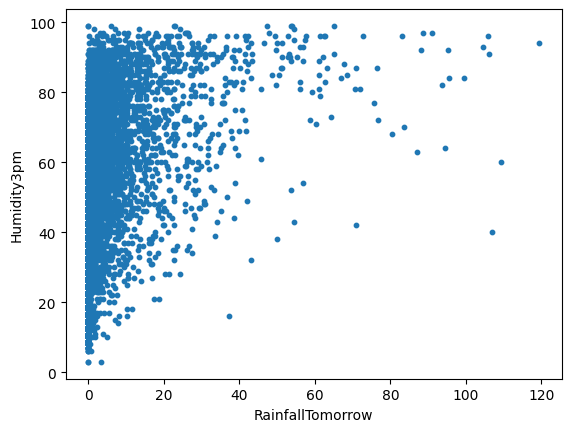

In [36]:
f ,ax = plt.subplots()
ax.scatter(df['RainfallTomorrow'], df['Humidity3pm'], s= 10)
ax.set_xlabel('RainfallTomorrow')
ax.set_ylabel('Humidity3pm')
plt.show()

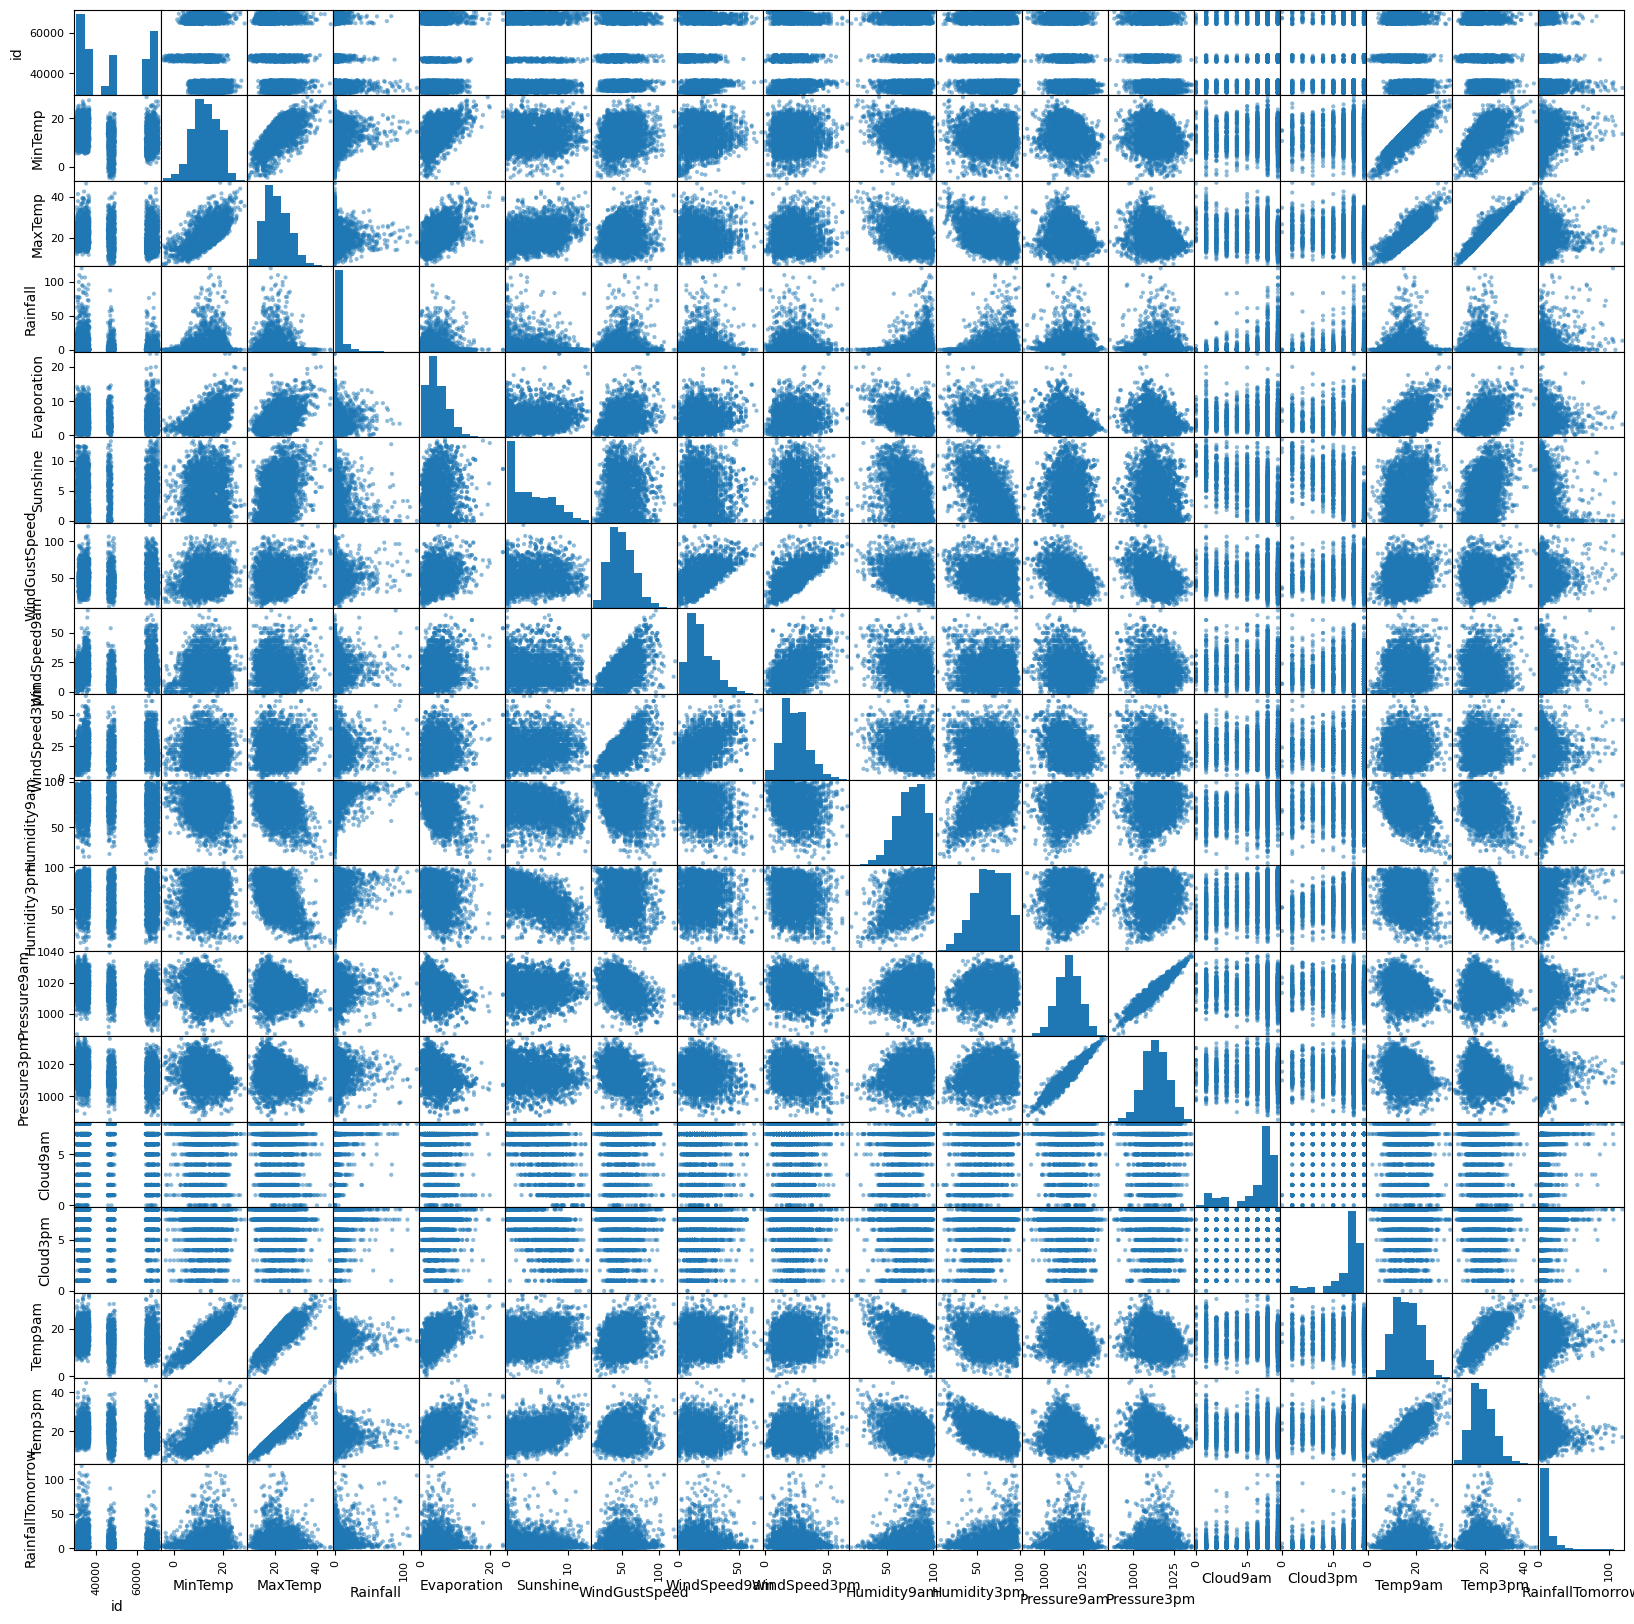

In [37]:
# Se analiza linealidad entre las distintas variables del dataset
pd.plotting.scatter_matrix(df_numeric[df_numeric.RainfallTomorrow > 1], figsize=(20,20))
warnings.simplefilter('ignore')

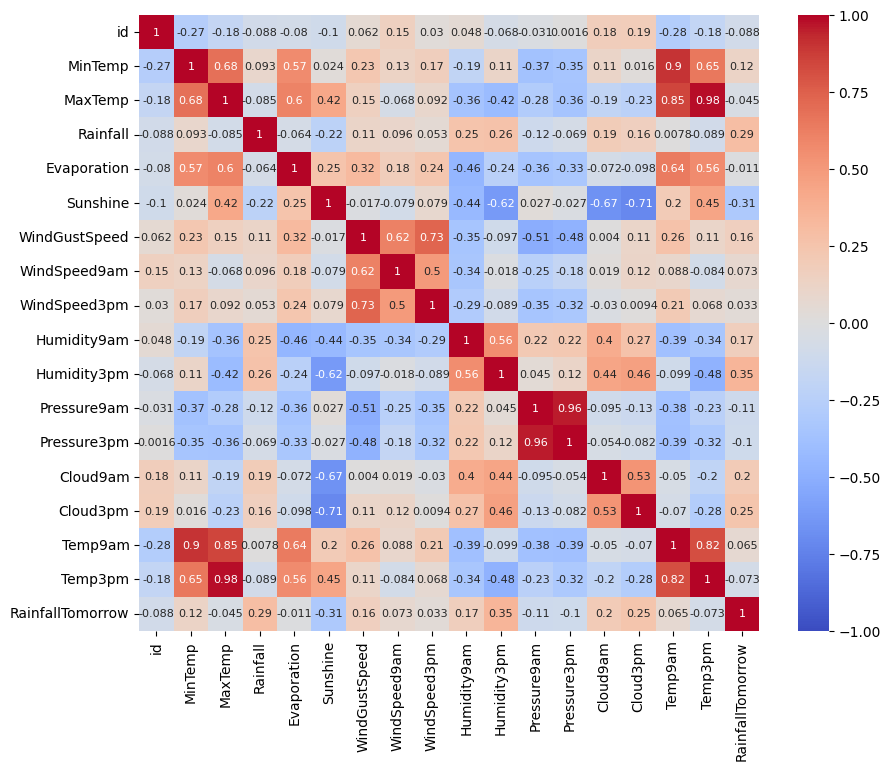

In [38]:
# Se analiza la correlacion lineal de las variables mediante un grafico de pearson
# Se observa:
# gran relacion lineal entre las 4 variables de temperaturas
# Relacion entre ambas pressure, humidity, cloud
# Relacion entre las distintas velocidades de viento

# Las variables que mayor relacion lineal con la variable objetivo RainfallTomorrow son:
# Rainfall, Sunshine, Humidity3pm, Cloud3pm, WindgustSpeed, MinTemp
# La relacion que se observa es bastante baja.

df_corr = df_numeric.corr()
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    df_corr,
    vmin=-1, vmax=1, center=0,
    cmap="coolwarm",
    annot = True,
    annot_kws={"size": 8},
)
plt.show()

**Seleccion de caracteristicas segun correlacion**



1.   Rainfall
2.   WindSpeed3pm
3.   WindGustSpeed
4.   Humidity3pm (lineal con Humidity9am)
5.   Cloud3pm (lineal con Cloud9am)
6.   MaxTemp (lineal con las otras temp)
7.   MinTemp (lineal con las otras temp)
8.   Pressure9am
9.   WindGustDir (E, N, S, W)
10.  RainToday (No, Yes)


# Regresion lineal

In [39]:
# En primera instancia se dividira el dataset el train y test.

# En la seleccion de caracteristicas se comprobo que la variable categoricas de las estaciones no aportaba informacion, se descartan.
# Regresion lineal utilizando caracteristicas seleccionadas previamente
# No se utiliza la variable RainTomorrow, pues no es un dato que se tenga a futuro
df_test = df[[
              'MinTemp', 'MaxTemp', 'Rainfall',  'WindGustSpeed', 'WindSpeed3pm',
              'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud3pm',
              'WindGustDir_E', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W',
              'RainToday_No', 'RainToday_Yes',
            ]]

X_train, X_test, y_train, y_test = train_test_split(df_test,
                                              df['RainfallTomorrow'].values.reshape(-1,1),
                                              test_size=0.1,
                                              random_state=12,
                                             )

# Dada la proporcion de na en las distintas columnas, donde solo en las columnas: Evaporation, Sunshine, Cloud9am y Cloud3pm llegan al 10%
# Se opto por reemplazar los valores faltantes por el promedio.
# Esta decision tiene como objetico no desperdiciar informacion/registros en las demas caracteristicas
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)

In [40]:
# Metodo para redondear numeros a 5 decimales
def round(number, decimals = 5):
  return np.around(number, decimals)

In [41]:
# Metodo que devuelve las metricas segun un y_test e y_prediccion
def metricas(y_test, y_pred):
  R2 = metrics.r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse_ols = mean_squared_error(y_test, y_pred, squared = False)
  mae = metrics.mean_absolute_error(y_test, y_pred)
  mape = metrics.mean_absolute_percentage_error(y_test, y_pred)

  print(f"R2: {round(R2)}")
  print(f"MSE: {round(mse)}")
  print(f"RMSE: {round(rmse_ols)}")
  print(f"MAE: {round(mae)}")
  print(f"MAPE: {round(mape)}")

In [42]:
model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metricas(y_test, y_pred)

R2: 0.19861
MSE: 54.73907
RMSE: 7.39859
MAE: 3.32848
MAPE: 4891966163921733.0


In [43]:
df_all = df.select_dtypes(include=['number']).drop('RainfallTomorrow', axis=1).drop('RainTomorrow_Yes', axis=1).drop('RainTomorrow_No', axis=1)

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
                                              df_all,
                                              df['RainfallTomorrow'].values.reshape(-1,1),
                                              test_size=0.1,
                                              random_state=12,)

X_train_all.fillna(X_train_all.mean(), inplace=True)
X_test_all.fillna(X_train_all.mean(), inplace=True)

In [44]:
# # Regresion utilizando todas las caracteristicas
# # Se observa un aumento en r2 producto de incluir mas variables en el modelo
# # El aumento es menor (0.02) lo que indica que la seleccion de caracteristicas es bastante optima
# # Las caracteristicas seleccionadas son representativas

# model = make_pipeline(StandardScaler(), LinearRegression())
# model.fit(X_train_all, y_train_all)

# y_pred_all = model.predict(X_test_all)

# metricas(y_test_all, y_pred_all)

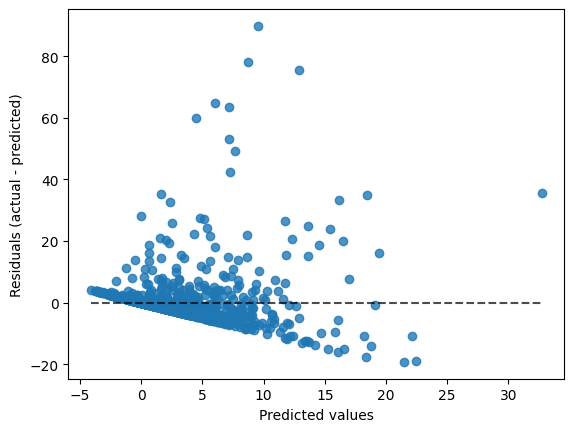

In [45]:
# Grafico de residuos

display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()
plt.show()

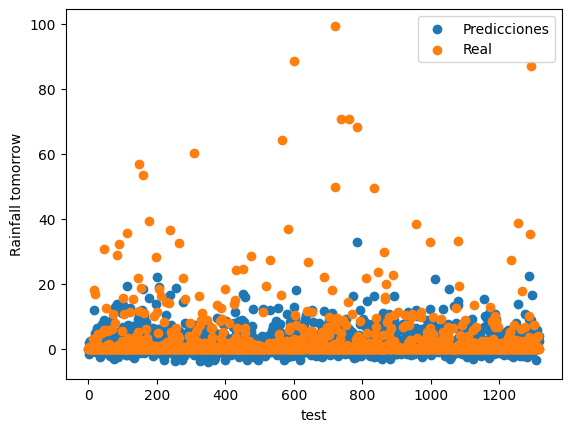

In [46]:
# Se observa que el modelo predice mejor los dias donde llueve poco (o nulo)
# No asi los dias donde llueve "mas"

x=range(len(y_test))
plt.scatter(x, y=y_pred, label='Predicciones')
plt.scatter(x, y=y_test, label='Real')
plt.ylabel("Rainfall tomorrow")
plt.xlabel("test")
plt.legend()
plt.show()

**Gradiente descendiente**

In [47]:
def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

In [48]:
# Crear un objeto StandardScaler
scaler = StandardScaler()

# Estandarizar los datos de entrenamiento y prueba
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

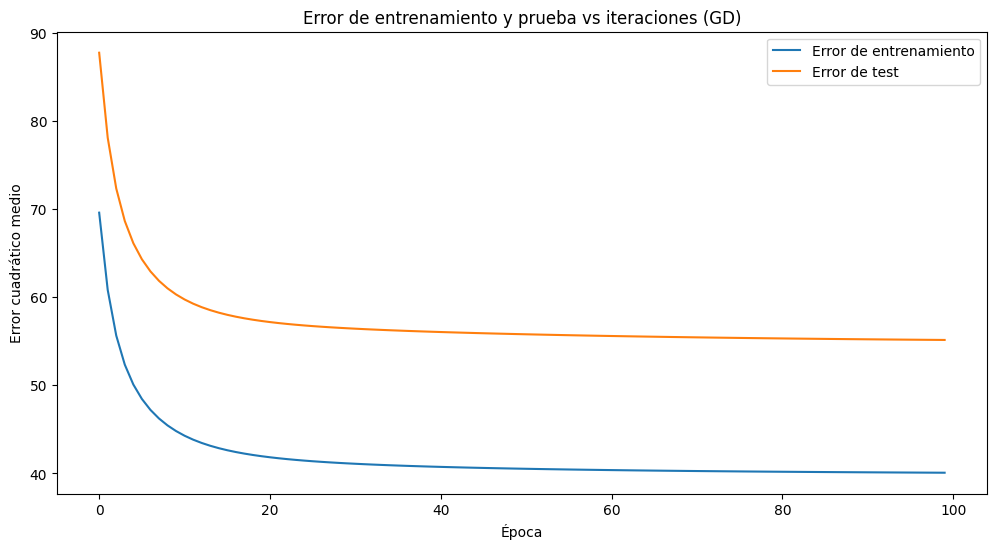

In [49]:
# Se observa como disminuye el MSE hasta aproximadamente 30 epocas, donde luego se mantiene en el valor ya obtenido con metodo lineal LinearRegressor

gradient_descent(X_train_standardized, y_train, X_test_standardized, y_test, lr=0.05, epochs=100)
warnings.simplefilter('ignore')

**Gradiente descendiente estocastico**

In [87]:
model = SGDRegressor(loss= 'squared_error', max_iter=1000, tol=1e-3)
model.fit(X_train_standardized, y_train)
yy = model.predict(X_test_standardized)
metricas(y_test, yy)
warnings.simplefilter('ignore')

R2: 0.20183
MSE: 54.51944
RMSE: 7.38373
MAE: 3.33123
MAPE: 4938472577983090.0


In [88]:
# from sklearn.linear_model import SGDRegressor
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# # Entrenar el modelo
# model = SGDRegressor(learning_rate='constant', eta0=0.01, max_iter=100)
# model.fit(X_train, y_train)

# # Obtener predicciones
# predictions_train = model.predict(X_train)
# predictions_test = model.predict(X_test)

# # Calcular errores
# error_train = y_train - predictions_train
# error_test = y_test - predictions_test

# # Calcular errores cuadráticos medios
# mse_train = mean_squared_error(y_train, predictions_train)
# mse_test = mean_squared_error(y_test, predictions_test)

# # Graficar los resultados
# plt.figure(figsize=(12, 6))
# plt.scatter(y_train, predictions_train, color='blue', label='Datos de entrenamiento')
# plt.scatter(y_test, predictions_test, color='red', label='Datos de prueba')
# plt.xlabel('Valores reales')
# plt.ylabel('Predicciones')
# plt.title('Predicciones vs Valores reales')
# plt.legend()
# plt.show()

# print(f'Error cuadrático medio en entrenamiento: {mse_train:.2f}')
# print(f'Error cuadrático medio en prueba: {mse_test:.2f}')

# warnings.simplefilter('ignore')

# Regularizacion

**Ridge**

In [52]:
# Se utiliza tecnica de Ridge para analizar sobre ajuste

model = make_pipeline(StandardScaler(),
                        RidgeCV(
                           alphas          = np.logspace(-10, 10, 200),
                           fit_intercept   = True,
                           store_cv_values = True
                        )
         )

model.fit(X_train_all, y_train_all)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00000000e-10, 1.26038293e-10, 1.58856513e-10, 2.00220037e-10,
       2.52353917e-10, 3.18062569e-10, 4.00880633e-10, 5.05263107e-10,
       6.36824994e-10, 8.02643352e-10, 1.01163798e-09, 1.27505124e-09,
       1.60705282e-09, 2.02550194e-09, 2.55290807e-09, 3.21764175e-09,
       4.05546074e-09, 5.11143348...
       4.88025158e+07, 6.15098579e+07, 7.75259749e+07, 9.77124154e+07,
       1.23155060e+08, 1.55222536e+08, 1.95639834e+08, 2.46581108e+08,
       3.10786619e+08, 3.91710149e+08, 4.93704785e+08, 6.22257084e+08,
       7.84282206e+08, 9.88495905e+08, 1.24588336e+09, 1.57029012e+09,
       1.97916687e+09, 2.49450814e+09, 3.14403547e+09, 3.96268864e+09,
       4.99450512e+09, 6.29498899e+09, 7.93409667e+09, 1.00000000e+10]),
                         store_cv_values=True))])

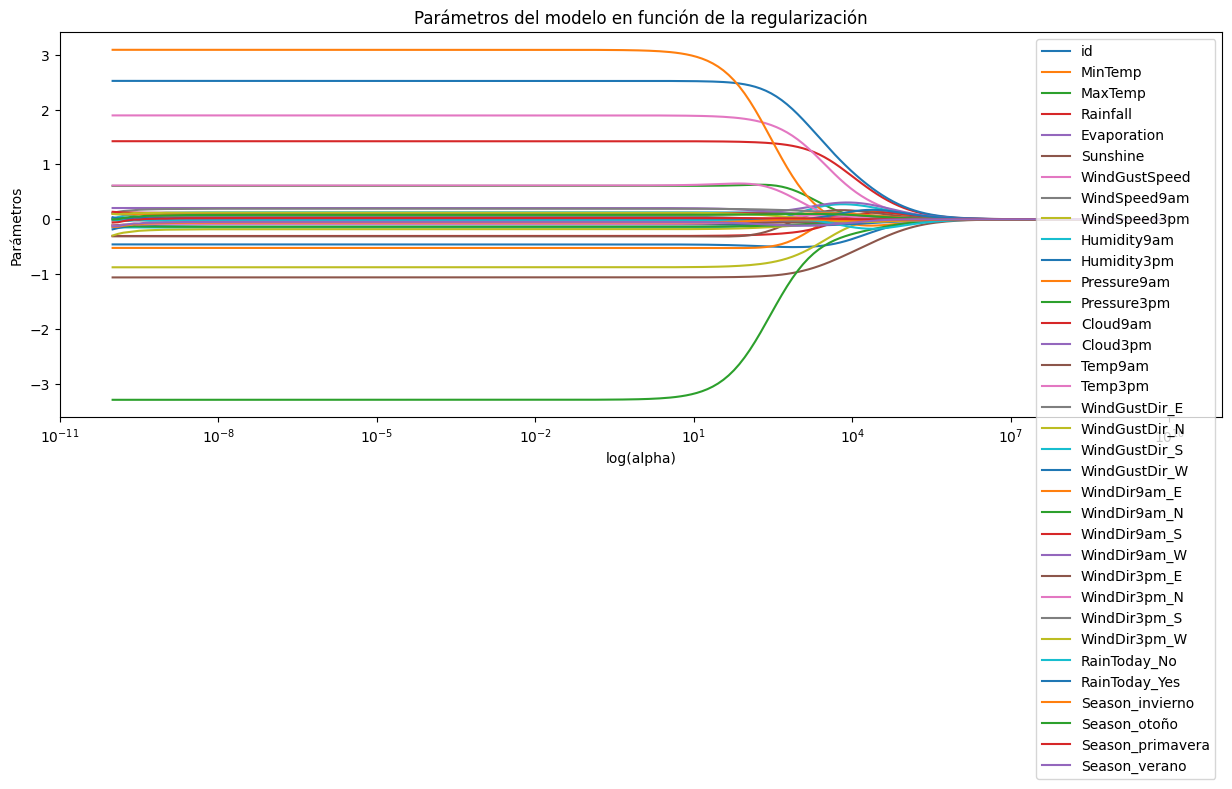

In [53]:
alphas = model.steps[1][1].alphas
coefs = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    modelo_aux.fit(X_train_all, y_train_all)
    coefs.append(modelo_aux.steps[1][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train_all.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
plt.axis('tight')
plt.legend()
plt.show()

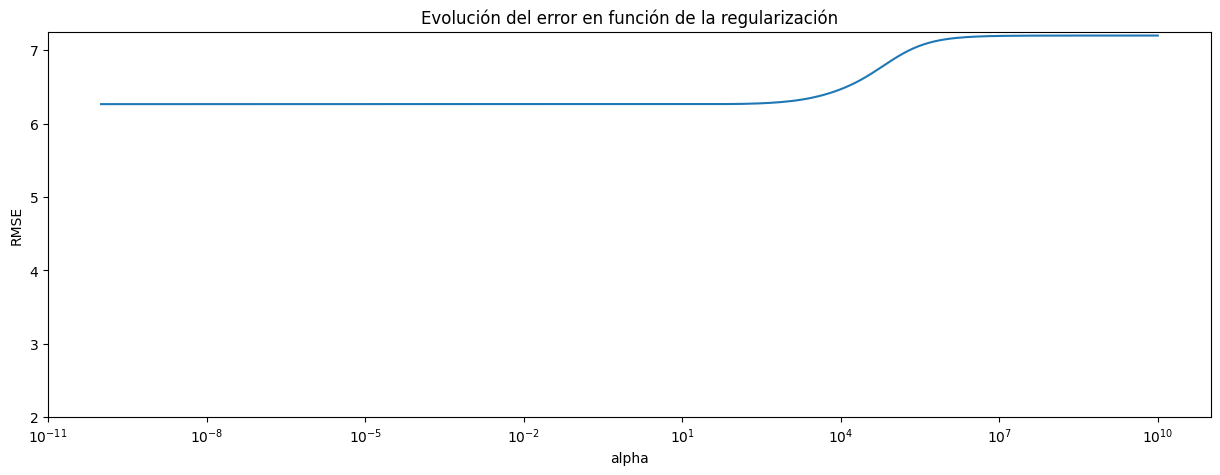

In [54]:
mod = model.steps[1][1]

mse_cv = mod.cv_values_.reshape((-1, 200)).mean(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Se identifica el mejor
min_rmse     = np.min(rmse_cv)
optimo       = mod.alphas[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(mod.alphas, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([2,None])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

In [55]:
print(f"Mejor valor de alpha encontrado: {mod.alpha_}")

Mejor valor de alpha encontrado: 11.357333583431075


In [56]:
y_pred_ridge = model.predict(X_test_all)

metricas(y_test_all, y_pred_ridge)

R2: 0.21524
MSE: 53.60327
RMSE: 7.32143
MAE: 3.31693
MAPE: 4835570029623248.0


## Lasso

In [57]:
# Se prueba tecnica de Lasso para analizar sobre ajuste

modelo = make_pipeline(StandardScaler(),
                        LassoCV(
                           alphas=np.logspace(-10, 10, 200),
                           cv=10
                        )
         )

_ = modelo.fit(X_train_all, y_train_all)

warnings.simplefilter('ignore')

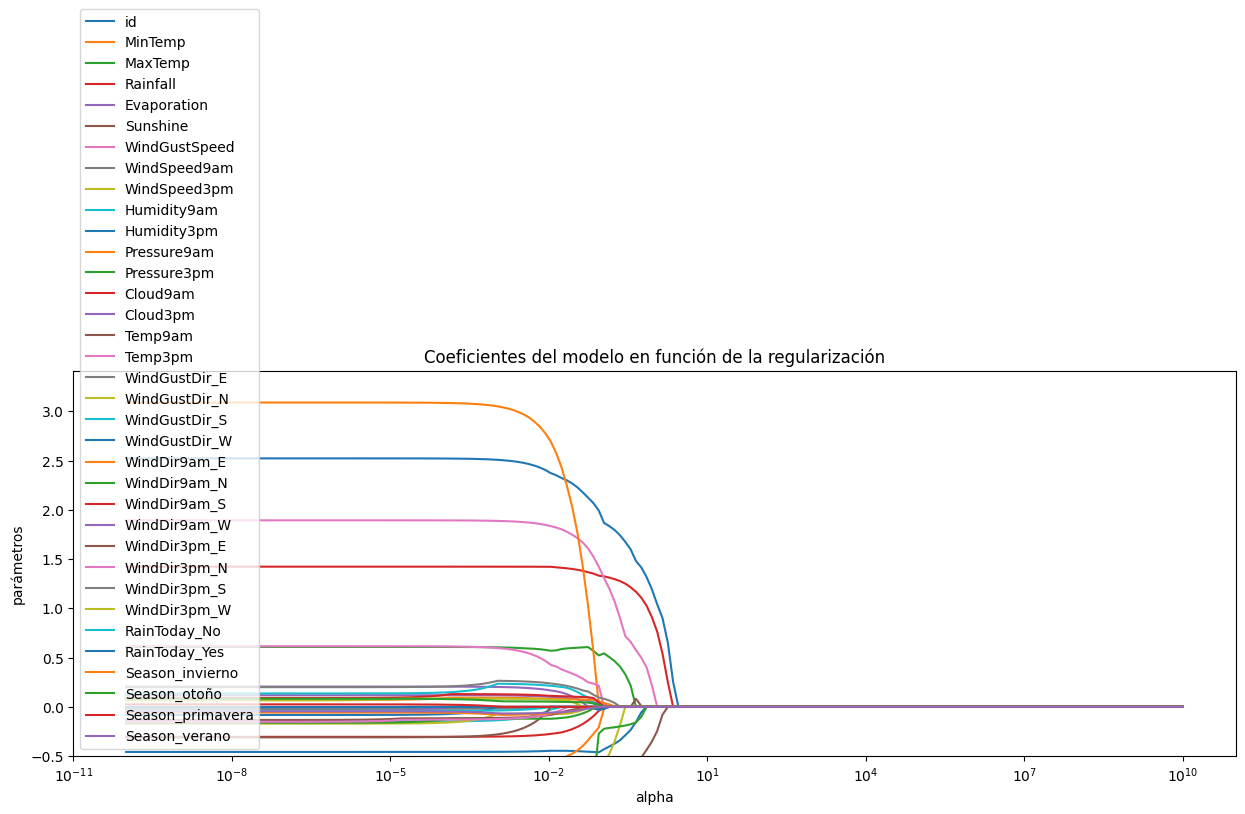

None

In [58]:
from IPython.display import display
mod = modelo.steps[1][1]

alphas = mod.alphas_
coefs = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Lasso(alpha=alpha))
    modelo_aux.fit(X_train_all, y_train_all)
    coefs.append(modelo_aux.steps[1][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs, label=X_train_all.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
display(plt.show())

warnings.simplefilter('ignore')

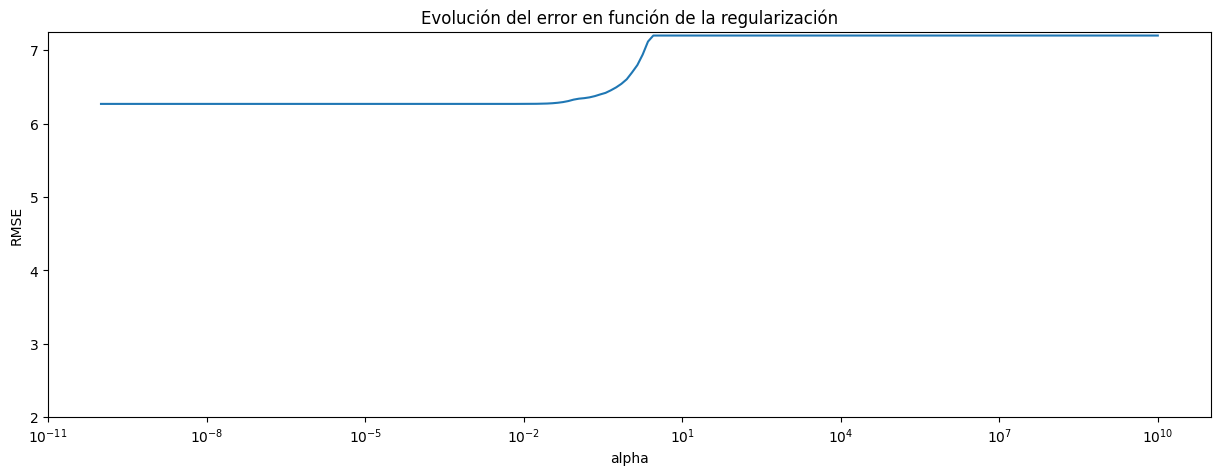

In [59]:
mse_cv = mod.mse_path_.mean(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Se identifica el mejor
min_rmse     = np.min(rmse_cv)
optimo       = mod.alphas_[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(mod.alphas_, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([2,None])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

In [60]:
y_pred_lasso = modelo.predict(X_test_all)

metricas(y_test_all, y_pred_lasso)

R2: 0.21487
MSE: 53.62893
RMSE: 7.32318
MAE: 3.31411
MAPE: 4823469336028868.0


Elastic Net

In [61]:
# Se utiliza tecnica de elastic net

modelo = make_pipeline(StandardScaler(),
                        ElasticNetCV(
                              l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                              alphas          = np.logspace(-10, 10, 200),
                              cv              = 10
                           )
         )

_ = modelo.fit(X_train_all, y_train_all)
mod = modelo.steps[1][1]

warnings.simplefilter('ignore')

In [62]:
# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = mod.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [mod.l1_ratio, mod.alphas_],
                                    names     = ['l1_ratio', 'mod.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

l1_ratio   mod.alphas_     mse_cv   rmse_cv
1324      0.99  3.448962e-03  39.293796  6.268476
1325      0.99  2.736440e-03  39.293814  6.268478
1125      0.95  2.736440e-03  39.293842  6.268480
1124      0.95  3.448962e-03  39.293856  6.268481
925       0.90  2.736440e-03  39.293892  6.268484
...        ...           ...        ...       ...
1027      0.95  1.933892e+07  51.842662  7.200185
1028      0.95  1.534368e+07  51.842662  7.200185
1029      0.95  1.217383e+07  51.842662  7.200185
1023      0.95  4.880252e+07  51.842662  7.200185
1054      0.95  3.739937e+04  51.842662  7.200185

[1400 rows x 4 columns]

In [63]:
print(f"Mejor valor de alpha encontrado: {mod.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {mod.l1_ratio_}")

Mejor valor de alpha encontrado: 0.0034489622604057598
Mejor valor de l1_ratio encontrado: 0.99


# Conclusiones generales

Se aplicaron distintas tecnicas de regresion lineal al dataset, luego de hacer una limpieza, seleccion de caracteristicas y estandarizacion.

Se obtuvo un valor de R2 aproximado de 0.21. Lo que significa que el modelo explica aproximadamente el 21.51% de la variabilidad en los datos. Este modelo lineal no es una buena aproximacion de lo que sucede en el dataset.

En general, este R2 sugiere que el modelo no se ajusta muy bien a los datos. Además, el MAPE extremadamente alto indica que las predicciones del modelo están muy lejos de los valores reales. Puede ser necesario considerar modelos más complejos u otras tecnicas para mejorar el rendimiento del modelo.

Se utilizaron las tecnicas de gradiente descendiente y gradiente descendiente estocastico, obteniendo metrticas similares a las obtenidas mediante una regresion lineal simple.

Se aplicaron tecnicas de regularizacion para analizar el sobre ajuste en las caracteristicas seleccionadas, observado que no mejoran las metricas.

# Regresión Logística

In [64]:
df_test_clas = df[[
              'MinTemp', 'MaxTemp', 'Rainfall',  'WindGustSpeed', 'WindSpeed3pm',
              'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud3pm',
              'WindGustDir_E', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W',
              'RainToday_No', 'RainToday_Yes'
            ]]


X_train_clas, X_test_clas, y_train_clas, y_test_clas = train_test_split(df_test_clas,
                                              df['RainTomorrow_Yes'].values.reshape(-1,1),
                                              test_size=0.1,
                                              random_state=12,
                                             )

X_train_clas.fillna(X_train_clas.mean(), inplace=True)
X_test_clas.fillna(X_train_clas.mean(), inplace=True)

In [65]:
# Balance del dataset
# Se observa gran desbalance con respecto a la variable a predecir RainTomorrow
# La cantidad de negativos es de mas del 70%

print(f"Cantidad de Negativos: {df.loc[:, 'RainTomorrow_Yes'].value_counts()[0]}")
print(f"Cantidad de Positivos: {df.loc[:, 'RainTomorrow_Yes'].value_counts()[1]}")

Cantidad de Negativos: 10149
Cantidad de Positivos: 3017


In [66]:
# Realizando un modelo de regresion logistica se puede observar los resultados esperados
# Unas metricas cercanas a 1 para los dias donde no llueve
# Mientras que para los dias de lluvia el modelo no acierta aproximandamente el 50% de las veces
# Esto puede ser debido al desbalanceo del dataset

log_model = LogisticRegression(random_state=12, max_iter=350)
log_model.fit(X_train_clas, y_train_clas)
y_pred_clas = log_model.predict(X_test_clas)

report_original = classification_report(y_test_clas, y_pred_clas)
print("Resultados")
print(report_original)

warnings.simplefilter('ignore')

Resultados
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1001
           1       0.75      0.50      0.60       316

    accuracy                           0.84      1317
   macro avg       0.80      0.72      0.75      1317
weighted avg       0.83      0.84      0.83      1317



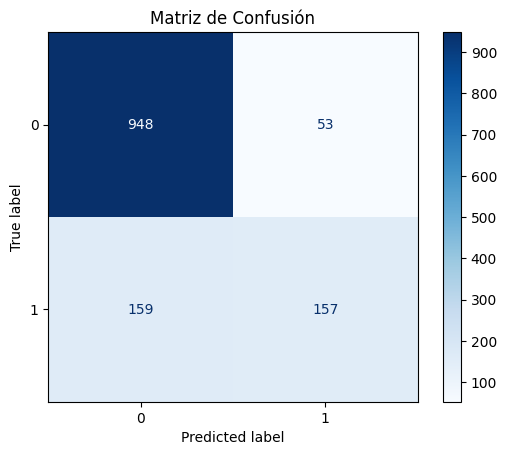

In [67]:
cm = confusion_matrix(y_test_clas, y_pred_clas)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)

plt.title('Matriz de Confusión')
plt.show()

In [68]:
#Roc Auc

y_probs = log_model.predict_proba(X_test_clas)[:, 1]
fpr, tpr, tresholds = roc_curve(y_test_clas, y_probs)
roc_auc = auc(fpr, tpr)

print(f"Se obtiene valor de RocAuc={roc_auc}")

Se obtiene valor de RocAuc=0.8572124078453194


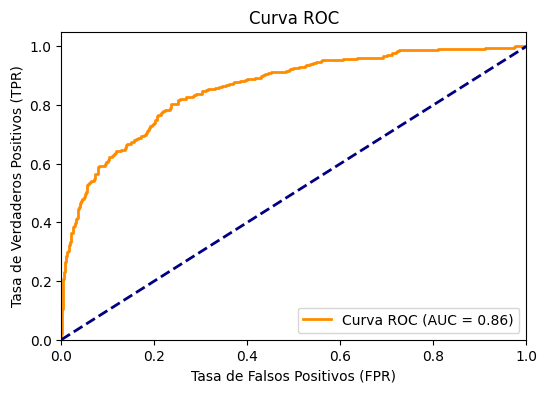

In [69]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [70]:
# Balanceando
# Se observa una caida en las metricas de los dias de no lluvia
# En favor de un gran aumento en la prediccion de dias que si llueve (recall sube de 0.51 a 0.76 mientras que la precision se ve reducida)

log_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_model.fit(X_train_clas, y_train_clas)
y_pred_clas = log_model.predict(X_test_clas)

print("Resultados")
print(classification_report(y_test_clas, y_pred_clas))


Resultados
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      1001
           1       0.53      0.75      0.62       316

    accuracy                           0.78      1317
   macro avg       0.72      0.77      0.73      1317
weighted avg       0.82      0.78      0.79      1317



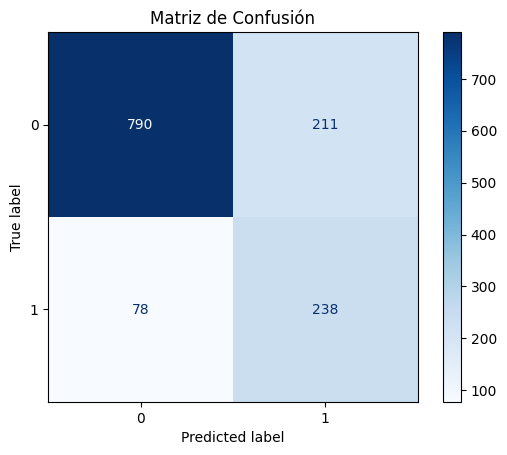

In [71]:
cm = confusion_matrix(y_test_clas, y_pred_clas)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)

plt.title('Matriz de Confusión')
plt.show()

In [72]:
# Oversampleo
# Se observa lo esperado, resultados similar al caso de modificar los pesos

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train_clas, y_train_clas)

In [73]:
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_resampled, y_resampled)
y_pred_clas = log_model.predict(X_test)

report_over = classification_report(y_test_clas, y_pred_clas)
print("Resultados con Oversampling")
print(report_over)


Resultados con Oversampling
              precision    recall  f1-score   support

           0       0.91      0.79      0.84      1001
           1       0.53      0.76      0.63       316

    accuracy                           0.78      1317
   macro avg       0.72      0.77      0.74      1317
weighted avg       0.82      0.78      0.79      1317



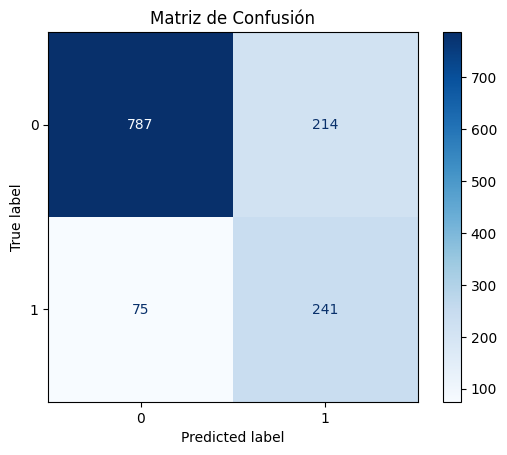

In [74]:
cm = confusion_matrix(y_test_clas, y_pred_clas)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)


plt.title('Matriz de Confusión')
plt.show()

In [75]:
# Undersampleo
# Utilizando la tecnica de under sampling se observa una leve mejora en las metricas

undersampler = RandomUnderSampler(random_state=42)
X_resampled_under, y_resampled_under = undersampler.fit_resample(X_train_clas, y_train_clas)

In [76]:
log_model_under = LogisticRegression(random_state=42, max_iter=1000)
log_model_under.fit(X_resampled, y_resampled)
y_pred_clas = log_model_under.predict(X_test_clas)
report_under = classification_report(y_test_clas, y_pred_clas)
print("Resultados con Undersampling")
print(report_under)

Resultados con Undersampling
              precision    recall  f1-score   support

           0       0.91      0.79      0.84      1001
           1       0.53      0.76      0.63       316

    accuracy                           0.78      1317
   macro avg       0.72      0.77      0.74      1317
weighted avg       0.82      0.78      0.79      1317



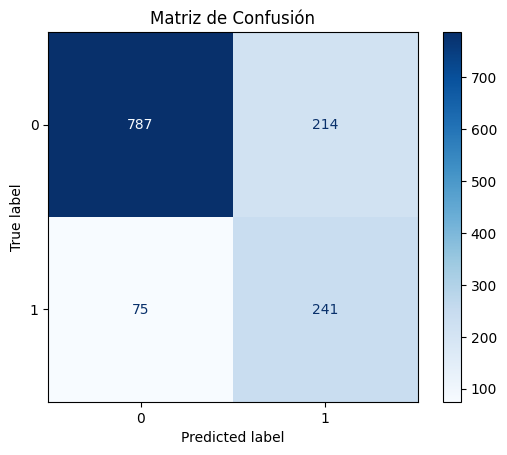

In [77]:
cm = confusion_matrix(y_test_clas, y_pred_clas)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)

plt.title('Matriz de Confusión')
plt.show()

In [78]:
# Near Miss

near_miss = NearMiss()
X_resampled, y_resampled = near_miss.fit_resample(X_train_clas, y_train_clas)

In [79]:
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_resampled, y_resampled)
y_pred_clas = log_model.predict(X_test_clas)

print("Resultados con Near Miss")
print(classification_report(y_test_clas, y_pred_clas))


Resultados con Near Miss
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1001
           1       0.48      0.71      0.58       316

    accuracy                           0.75      1317
   macro avg       0.69      0.74      0.70      1317
weighted avg       0.80      0.75      0.76      1317



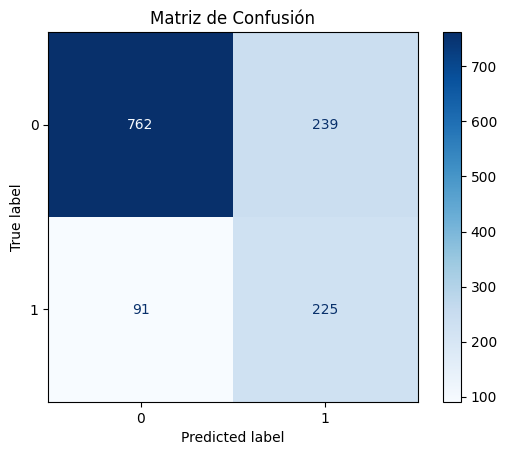

In [80]:
cm = confusion_matrix(y_test_clas, y_pred_clas)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)

plt.title('Matriz de Confusión')
plt.show()

In [81]:
print("Resultados antes de balancear")
print(report_original)

print("Resultados con Undersampling")
print(report_over)

Resultados antes de balancear
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1001
           1       0.75      0.50      0.60       316

    accuracy                           0.84      1317
   macro avg       0.80      0.72      0.75      1317
weighted avg       0.83      0.84      0.83      1317

Resultados con Undersampling
              precision    recall  f1-score   support

           0       0.91      0.79      0.84      1001
           1       0.53      0.76      0.63       316

    accuracy                           0.78      1317
   macro avg       0.72      0.77      0.74      1317
weighted avg       0.82      0.78      0.79      1317



Decidimos elegir el balanceo por Undersampling ya que nuestro objetivo es aumentar el recall de la clase 1. Esto es para priorizar la identificación correcta de los días de lluvia, incluso si eso significa que el modelo pueda clasificar incorrectamente algunos días como lluvia cuando no lo son (falsos positivos). :

Se puede observar que la presicion para la clase 1 (llueve) es 0.53, lo que significa que el 53% de las veces que el modelo predijo lluvia, realmente llovió. Para los dias que no llovió el valor es mucho mas alto de 0.91, es mas preciso para los dias que no llueve.

En cuanto a la sensibilidad (recall en la grafica), el valor para los dias de lluvia es 0.77, lo que indica que el modelo captura el 77% de todos los eventos reales de lluvia, osea que identifica correctamente la lluvia el 77% de las veces. Una mejora al 51% que teniamos originalmente.

En cuanto la F1 se logra una mejoria despues de balncear para la clase 1 a costa de empeorar la clase 0.


Precision y Recall:

Precisión (Precision): Para la clase 0 (sin lluvia), la precisión es 0.91, lo que significa que el 91% de las veces que el modelo predijo que no llovería, realmente no llovió. En otras palabras, cuando el modelo dice que no lloverá, generalmente está en lo correcto (91% de las veces).
Recall (Sensibilidad): La recuperación para la clase 0 es 0.79, lo que indica que el modelo captura el 79% de todos los eventos reales de días sin lluvia. En otras palabras, el modelo identifica correctamente los días sin lluvia el 79% de las veces.

F1-Score:

El F1-score para la clase 0 es 0.85. El F1-score es la media armónica de precisión y recuperación. Es útil cuando las clases están desequilibradas, como parece ser el caso aquí.
Conclusión:

Para los días que no llueven, el modelo tiene una alta precisión (91%) y una recuperación razonable (79%). Esto significa que cuando el modelo predice un día sin lluvia, generalmente está en lo correcto. Además, el F1-score de 0.85 indica un buen equilibrio entre precisión y recuperación para esta clase.
En resumen, el modelo tiene un rendimiento bastante sólido para predecir días sin lluvia, con una alta precisión y una recuperación razonable. Es importante tener en cuenta que, en este caso, el modelo parece ser mejor para predecir días sin lluvia (clase 0) en comparación con los días de lluvia (clase 1).

Cuando los dos valores de recall para las clases positiva y negativa son similares, significa que el modelo tiene una capacidad equilibrada para capturar ambas clases. En otras palabras, el modelo es igualmente bueno para predecir tanto los casos positivos como los negativos.

El recall indica la proporción de casos reales que el modelo ha identificado correctamente. Un alto valor de recall significa que el modelo puede identificar la mayoría de los casos positivos en el conjunto de datos.

Cuando los valores de recall son similares para ambas clases, sugiere que el modelo no tiene un sesgo significativo hacia ninguna de las clases. Por ejemplo, si el modelo tiene un recall alto para la clase positiva (lluvia) pero un recall bajo para la clase negativa (sin lluvia), podría significar que el modelo está demasiado enfocado en predecir los casos positivos y está pasando por alto muchos de los casos negativos. Esto sería un problema en situaciones en las que predecir los casos negativos es igualmente importante.

En resumen, tener valores de recall similares para ambas clases indica que el modelo es equitativo en su capacidad para identificar tanto los casos positivos como los negativos, lo que es deseable en muchos escenarios, especialmente cuando las clases están equilibradas en el conjunto de datos.






**Busqueda de Hiperparametros**

In [82]:
log_model = LogisticRegression(random_state=12, max_iter=350)

param_grid = {'C': [10, 100, 1000, 1100, 1500], 'penalty': ['l1', 'l2']}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

grid_search = GridSearchCV(log_model, param_grid, scoring='recall', cv=kfold)

grid_search.fit(X_train_clas, y_train_clas)

print("Mejores Hiperparámetros:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred_clas = best_model.predict(X_test_clas)


recall = recall_score(y_test_clas, y_pred_clas)
print(f"Recall del Modelo en el Conjunto de Prueba: {recall:.4f}")

Mejores Hiperparámetros: {'C': 1000, 'penalty': 'l2'}
Recall del Modelo en el Conjunto de Prueba: 0.5095


# Modelos Base

Para la elección del modelo base para la regresión lineal nos basamos en que  la mayor cantidad de dias no llueve (Rainfall = 0), por este motivo decidimos elegir un modelo base que retorne 0 en todos los casos.

In [83]:
from sklearn.base import BaseEstimator, RegressorMixin

class BaseRegressor(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        # Retorna 0 para todo.
        return 0

    def predict(self, X):
        return np.array(X.shape[0]*[0])

In [84]:
base_regressor = BaseRegressor()
model = make_pipeline(StandardScaler(), BaseRegressor())
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

metricas(y_test, y_pred)

R2: -0.09154
MSE: 74.55806
RMSE: 8.6347
MAE: 2.50053
MAPE: 0.388


Para el case de la regresión logista tomamos el mismo criterio debido a que la mayor proporcion de días no llueve. PAra este caso también tomamos un modelo base que devuelva 0 par todos los casos.

In [85]:
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, ClassifierMixin

class ConstantZeroClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):

        # Ajuste ficticio
        # En este ejemplo, asignamos algún valor constante como si hubiéramos ajustado el modelo.
        self._is_fitted = True
        self.fitted_value_ = 42

        return self

    def predict(self, X):

        # Devolver siempre cero, independientemente de los datos de entrada
        return np.zeros(X.shape[0], dtype=int)


model = ConstantZeroClassifier()
model.fit(X_train_clas, y_train_clas)


y_pred = model.predict(X_test_clas)
print(classification_report(y_test_clas, y_pred_clas))


              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1001
           1       0.76      0.51      0.61       316

    accuracy                           0.84      1317
   macro avg       0.81      0.73      0.76      1317
weighted avg       0.84      0.84      0.83      1317



#Red Neuronal

Se implementará un modelo de red neuronal para resolver los mismos problemas. Se diseñará una red con 1 capa de entrada, 2 capas ocultas y una de salida. En el caso de la regresión la salida utilizará una funciónd de activación lineal y para el caso de clasificación una sigmoidea.
Se minimizará el error en MSE y Binnary cross entropy respectivamente.

**Prediccion de lluvia**

Epoch 1/300
27/27 [==============================] - 2s 22ms/step - loss: 53.5782 - mse: 53.5782 - val_loss: 60.9467 - val_mse: 60.9467
Epoch 2/300
27/27 [==============================] - 0s 12ms/step - loss: 49.1026 - mse: 49.1026 - val_loss: 55.0215 - val_mse: 55.0215
Epoch 3/300
27/27 [==============================] - 0s 11ms/step - loss: 44.8022 - mse: 44.8022 - val_loss: 49.8527 - val_mse: 49.8527
Epoch 4/300
27/27 [==============================] - 0s 12ms/step - loss: 42.0850 - mse: 42.0850 - val_loss: 46.9664 - val_mse: 46.9664
Epoch 5/300
27/27 [==============================] - 0s 10ms/step - loss: 40.9037 - mse: 40.9037 - val_loss: 45.4112 - val_mse: 45.4112
Epoch 6/300
27/27 [==============================] - 0s 10ms/step - loss: 40.1236 - mse: 40.1236 - val_loss: 44.1699 - val_mse: 44.1699
Epoch 7/300
27/27 [==============================] - 0s 11ms/step - loss: 39.4897 - mse: 39.4897 - val_loss: 43.1730 - val_mse: 43.1730
Epoch 8/300
27/27 [=============================

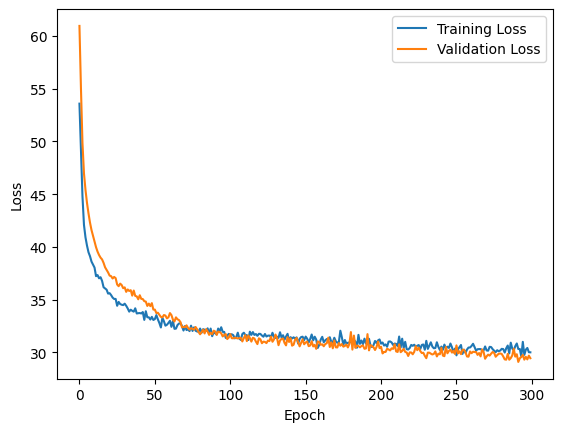

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = tf.keras.Sequential([
          tf.keras.layers.Dense(15, activation='relu', input_shape=(X_train_scaled.shape[1],)),
          tf.keras.layers.Dropout(0.063),
          tf.keras.layers.Dense(18, activation='leaky_relu'),
          tf.keras.layers.Dense(9, activation='leaky_relu'),
          tf.keras.layers.Dense(1, activation='linear')
        ])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

history = model.fit(X_train_scaled, y_train, epochs=300, batch_size=400, validation_split=0.1)

loss, mae = model.evaluate(X_test_scaled, y_test)

# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test_scaled)
metricas(y_test, y_pred)

42/42 [==============================] - 0s 2ms/step
R2: 0.34584
MSE: 44.68271
RMSE: 6.68451
MAE: 2.69408
MAPE: 2818774200380535.5


Luego de entrenar el modelo se observa un aumento en el r2 a 0.35, lo que representa una mejora con respecto al modelo de regresión lineal simple. Para poder mejorar estas métricas es necesario hacer un análisis de los hiper parámetros.

**Tuning de Hiperparámetros**

In [ ]:
## Se utilizara OPTUNA, dado que es lo mas optimo pare redes neuronales.
## Utilizar otro metodo podria tomar una cantidad enorme de tiempo, debido a la cantidad de parametros.

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential

# Función de objetivo para Optuna
def objetivo(trial):
    # Definir el modelo
    model = Sequential([
        Dense(15, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(trial.suggest_float('dropout_capa1', 0.0, 0.5)),
        Dense(trial.suggest_int('neuronas_capa2', 3, 20), activation=LeakyReLU()),
        Dense(trial.suggest_int('neuronas_capa3', 2, 10), activation=LeakyReLU()),
        Dense(1, activation='linear')
    ])

    # Compilar el modelo
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    # Entrenar el modelo
    history = model.fit(X_train_scaled, y_train, epochs=30, batch_size=trial.suggest_int('batch_size', 32, 512), validation_split=0.1, verbose=0)

    # Devolver la métrica que se desea minimizar
    return model.evaluate(X_train_scaled, y_train, verbose=0)[0]


# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Configurar el estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objetivo, n_trials=50)

# Obtener los mejores hiperparámetros encontrados
mejores_parametros = study.best_params
print("Mejores parámetros:", mejores_parametros)

# Construir el modelo final con los mejores parámetros
modelo_final = Sequential([
    Dense(15, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(mejores_parametros['dropout_capa1']),
    Dense(mejores_parametros['neuronas_capa2'], activation=LeakyReLU()),
    Dense(mejores_parametros['neuronas_capa3'], activation=LeakyReLU()),
    Dense(1, activation='linear')
])

# Compilar el modelo final
modelo_final.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Entrenar el modelo final con todos los datos de entrenamiento
modelo_final.fit(X_train_scaled, y_train, epochs=300, batch_size=mejores_parametros['batch_size'], validation_split=0.1, verbose=1)

# Evaluar el modelo final en los datos de prueba
loss, mse = modelo_final.evaluate(X_test_scaled, y_test)
print(f"Pérdida en datos de prueba: {loss}, MSE en datos de prueba: {mse}")


In [ ]:
## Mejores parámetros: {'dropout_capa1': 0.06306510872841382, 'neuronas_capa2': 18, 'neuronas_capa3': 9, 'batch_size': 35}

**Explicabilidad con SHAP**

PermutationExplainer explainer: 1318it [00:33, 28.07it/s]


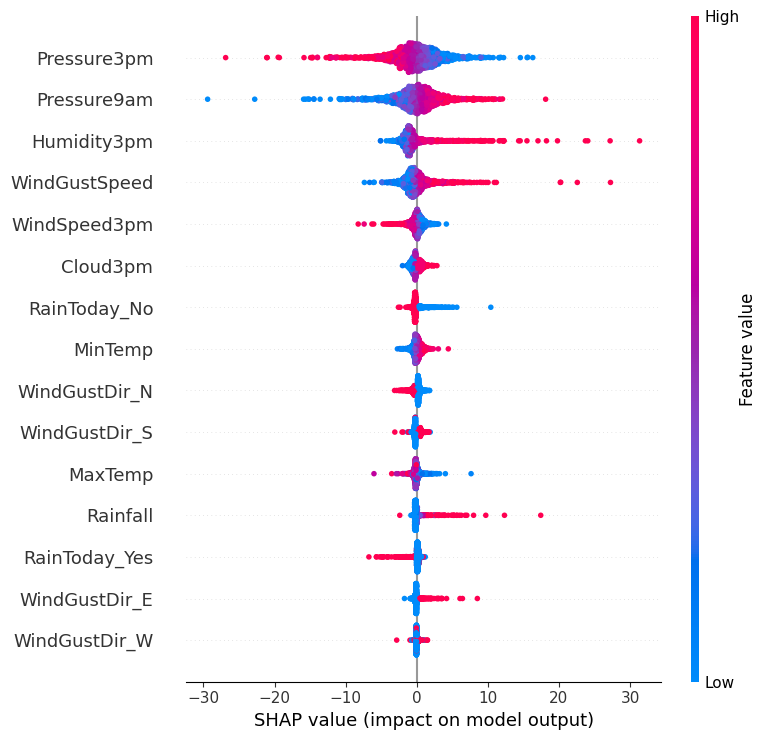

In [ ]:
## Interpretabilidad GLOBAL

# Calcular SHAP values
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# Resumen de los SHAP values
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

plt.show()

## El siguiente grafico de enjambre de abejas permite visualizar como impactan las distintas features en las predicciones a nivel global
## Siendo un valor rojo un mayor valor de la feature, y azul un menor valor. Se visualizan los valores de SHAP en el indice x. Donde un mayor valor nos indica
## mayor impacto en la prediccion y vice versa.
## Por otro lado, el acumulamiento de puntos indica que gran cantidad de registros de test se agrupan en esa zona.

## En er el grafico se puede visualizar que gran cantidad de datos en las distintas features no tienen un impacto muy elevado en la salida, mas bien afectan positiva o negativamente en menor cantidad.

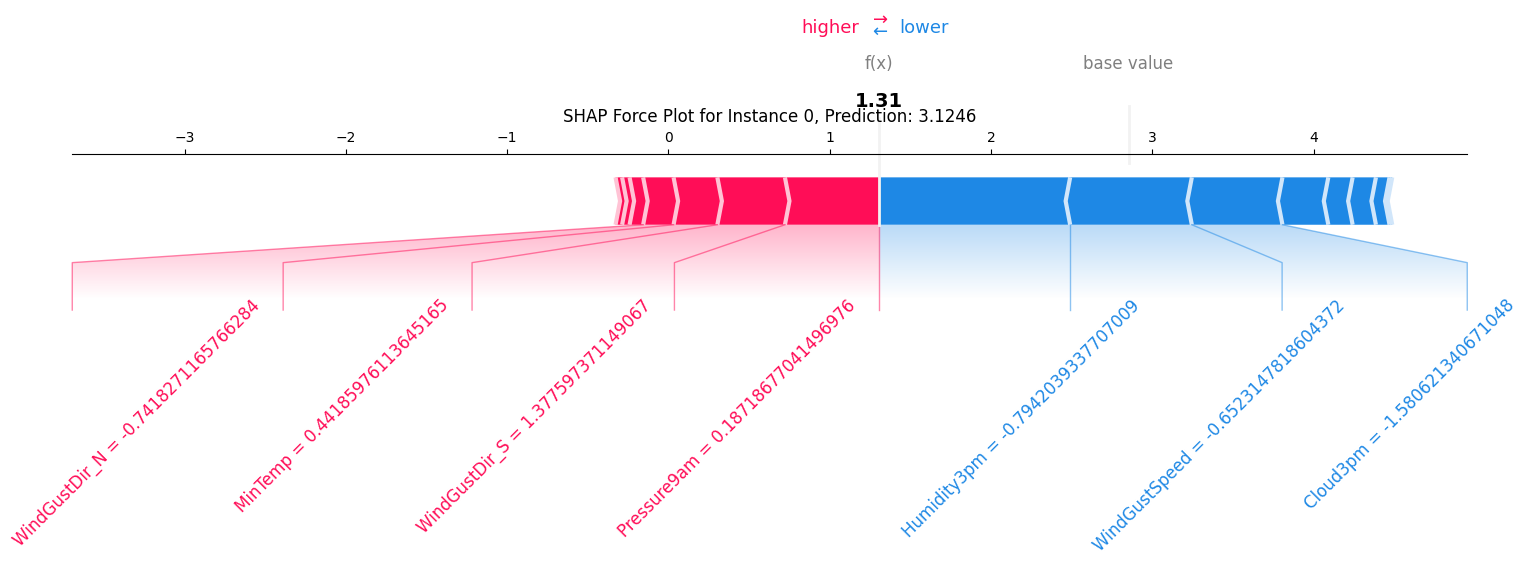

In [ ]:
## Interpretabilidad LOCAL

explainer = shap.DeepExplainer(model, X_train_scaled)

index = 0

shap_value_scalar = shap_values[index][0]

shap.force_plot(explainer.expected_value[0].numpy(), shap_values[index], X_test_scaled[index], feature_names=X_train.columns, matplotlib=True, show=False,figsize=(18, 4), text_rotation=45)

plt.title(f"SHAP Force Plot")
plt.show()

## En este grafico se puede observar la prediccion y cuales son las variables que hicieron una contribucion positiva (rojo) y negativa (azul)
## Donde se destacan las features que mayor influencia tuvieron en el resultado.
## Este grafico es local, para una prediccion en particular, puede dar completamente distinto si tomamos otros registros de test.

# **Clasificacion**

Epoch 1/300
14/14 [==============================] - 5s 7ms/step - loss: 0.7415 - binary_crossentropy: 0.7415
Epoch 2/300
14/14 [==============================] - 0s 6ms/step - loss: 0.6930 - binary_crossentropy: 0.6930
Epoch 3/300
14/14 [==============================] - 0s 6ms/step - loss: 0.6578 - binary_crossentropy: 0.6578
Epoch 4/300
14/14 [==============================] - 0s 6ms/step - loss: 0.6260 - binary_crossentropy: 0.6260
Epoch 5/300
14/14 [==============================] - 0s 4ms/step - loss: 0.5978 - binary_crossentropy: 0.5978
Epoch 6/300
14/14 [==============================] - 0s 4ms/step - loss: 0.5756 - binary_crossentropy: 0.5756
Epoch 7/300
14/14 [==============================] - 0s 4ms/step - loss: 0.5552 - binary_crossentropy: 0.5552
Epoch 8/300
14/14 [==============================] - 0s 3ms/step - loss: 0.5466 - binary_crossentropy: 0.5466
Epoch 9/300
14/14 [==============================] - 0s 4ms/step - loss: 0.5366 - binary_crossentropy: 0.5366
Epoch 10/3

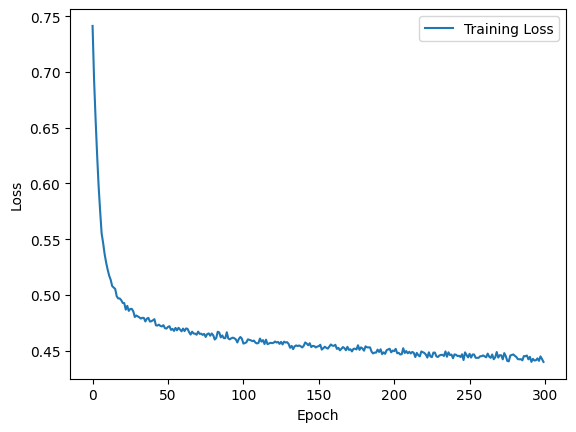

In [92]:
import keras

# OBSERVACION: El dataset ya se encuentra balanceado del item anterior.

scaler = StandardScaler()
X_train_scaled_clas = scaler.fit_transform(X_resampled_under)
X_test_scaled_clas = scaler.transform(X_test_clas)


model = tf.keras.Sequential([
          tf.keras.layers.Dense(15, activation='relu', input_shape=(X_train_scaled_clas.shape[1],)),
          tf.keras.layers.Dropout(0.07),
          tf.keras.layers.Dense(19, activation='leaky_relu'),
          tf.keras.layers.Dense(10, activation='leaky_relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy'])

history = model.fit(X_train_scaled_clas, y_resampled_under, epochs=300, batch_size=400)#, validation_split=0.1)

loss, _ = model.evaluate(X_test_scaled_clas, y_test_clas)

# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [93]:
y_pred_clas = model.predict(X_test_scaled_clas)
y_pred_clas = tf.squeeze(y_pred_clas)
y_pred_clas = np.array([1 if x >= 0.5 else 0 for x in y_pred_clas])
y_test_clas = np.array(y_test_clas)

42/42 [==============================] - 0s 2ms/step


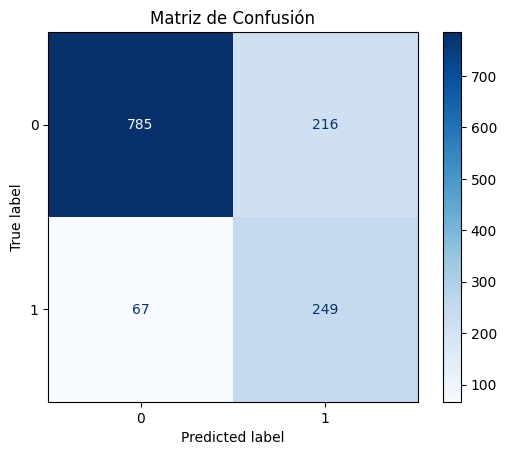

In [94]:
_cm = confusion_matrix(y_test_clas, y_pred_clas)

disp = ConfusionMatrixDisplay(confusion_matrix=_cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)

plt.title('Matriz de Confusión')
plt.show()

In [95]:
print(classification_report(y_test_clas, y_pred_clas))

              precision    recall  f1-score   support

           0       0.92      0.78      0.85      1001
           1       0.54      0.79      0.64       316

    accuracy                           0.79      1317
   macro avg       0.73      0.79      0.74      1317
weighted avg       0.83      0.79      0.80      1317



En el caso de la clasificación no se observa cambios en las métricas de recall, precision y f1, si se observa un aumento en accuracy.

**Tuning de Hiperparámetros**

In [ ]:
## Se utilizara OPTUNA, dado que es lo mas optimo pare redes neuronales.
## Utilizar otro metodo podria tomar una cantidad enorme de tiempo, debido a la cantidad de parametros.

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential

# Función de objetivo para Optuna
def objetivo(trial):
    # Definir el modelo
    model = Sequential([
        Dense(15, activation='relu', input_shape=(X_train_scaled_clas.shape[1],)),
        Dropout(trial.suggest_float('dropout_capa1', 0.0, 0.5)),
        Dense(trial.suggest_int('neuronas_capa2', 3, 20), activation=LeakyReLU()),
        Dense(trial.suggest_int('neuronas_capa3', 2, 10), activation=LeakyReLU()),
        Dense(1, activation='sigmoid')
    ])

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy'])

    # Entrenar el modelo
    history = model.fit(X_train_scaled_clas, y_resampled_under, epochs=30, batch_size=trial.suggest_int('batch_size', 32, 512), verbose=0)

    # Devolver la métrica que se desea minimizar
    return model.evaluate(X_train_scaled_clas, y_resampled_under, verbose=0)[0]


# Escalar datos
scaler = StandardScaler()
X_train_scaled_clas = scaler.fit_transform(X_resampled_under)
X_test_scaled_clas = scaler.transform(X_test_clas)

# Configurar el estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objetivo, n_trials=50)

# Obtener los mejores hiperparámetros encontrados
mejores_parametros = study.best_params
print("Mejores parámetros:", mejores_parametros)

# Construir el modelo final con los mejores parámetros
modelo_final = Sequential([
    Dense(15, activation='relu', input_shape=(X_train_scaled_clas.shape[1],)),
    Dropout(mejores_parametros['dropout_capa1']),
    Dense(mejores_parametros['neuronas_capa2'], activation=LeakyReLU()),
    Dense(mejores_parametros['neuronas_capa3'], activation=LeakyReLU()),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo final
modelo_final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy'])

# Entrenar el modelo final con todos los datos de entrenamiento
modelo_final.fit(X_train_scaled_clas, y_resampled_under, epochs=300, batch_size=mejores_parametros['batch_size'], verbose=1)

# Evaluar el modelo final en los datos de prueba
loss, binary_crossentropy = modelo_final.evaluate(X_test_scaled_clas, y_test_clas)
print(f"Pérdida en datos de prueba: {loss}, Binary Crossentropy en datos de prueba: {binary_crossentropy}")


In [ ]:
## Mejores parámetros: {'dropout_capa1': 0.07966467359522736, 'neuronas_capa2': 19, 'neuronas_capa3': 10, 'batch_size': 32}

Explicabilidad con SHAP

PermutationExplainer explainer: 1318it [00:35, 29.34it/s]


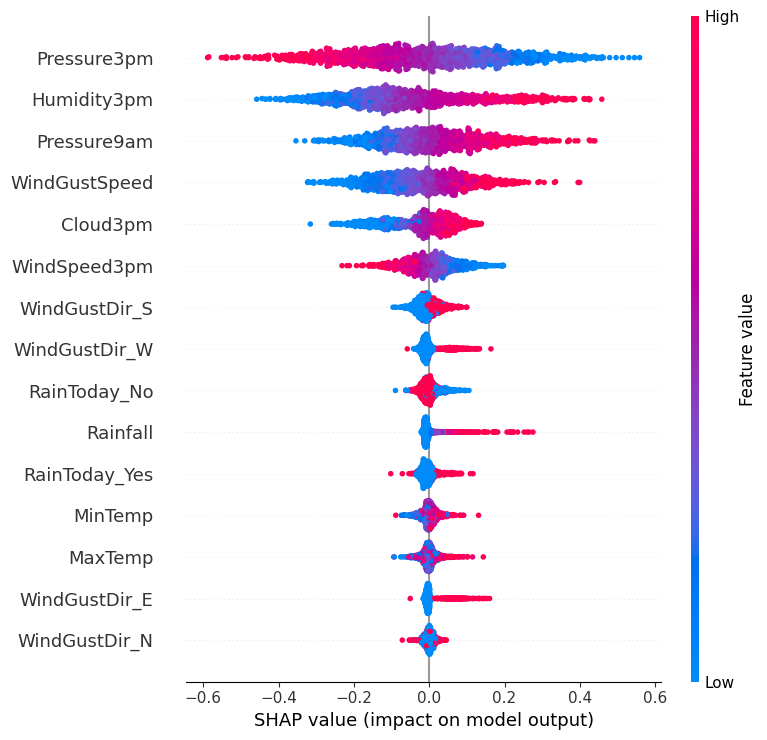

In [ ]:
## Interpretabilidad GLOBAL

explainer = shap.Explainer(model, X_train_scaled_clas)
shap_values = explainer.shap_values(X_test_scaled_clas)


shap.summary_plot(shap_values, X_test_scaled_clas, feature_names=X_train_clas.columns)


## En el caso de clasificacion, a diferencia de la prediccion de lluvia, se observa que las distintas features aportan mas significativamente
## a la prediccion.

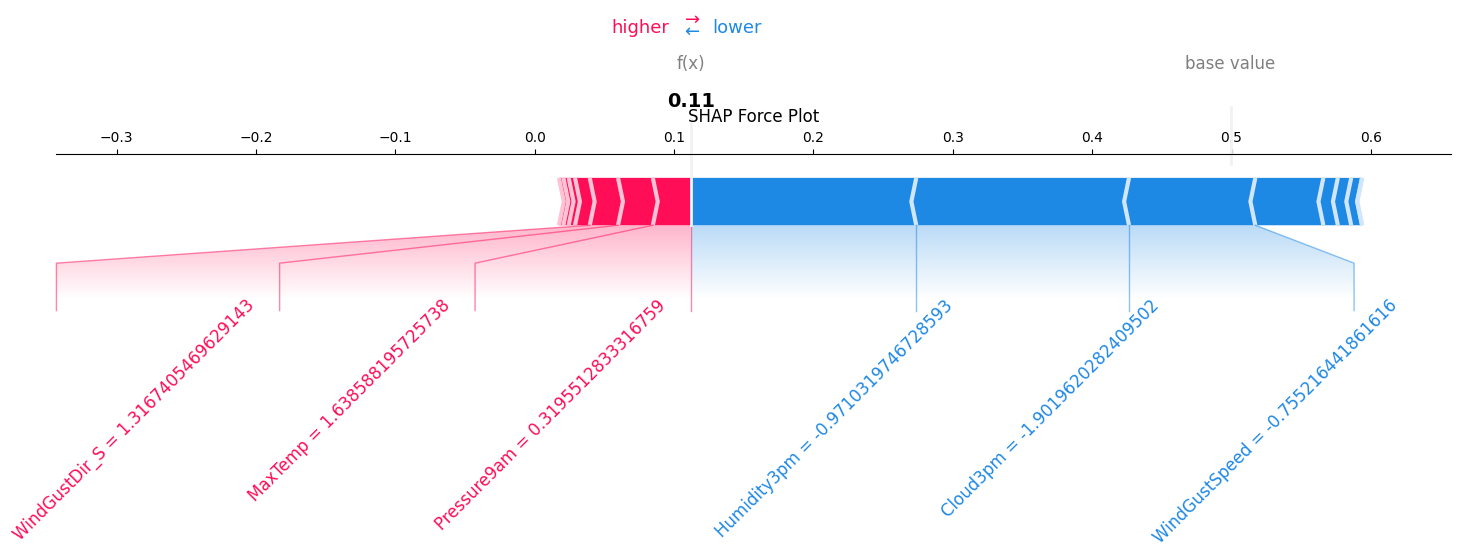

In [ ]:
## Interpretabilidad LOCAL

explainer = shap.DeepExplainer(model, X_train_scaled_clas)

index = 0

shap_value_scalar = shap_values[index][0]

shap_plot = shap.force_plot(explainer.expected_value[0].numpy(), shap_values[index], X_test_scaled_clas[index], feature_names=X_train_clas.columns, matplotlib=True, show=False,figsize=(18, 4), text_rotation=45)

plt.title(f"SHAP Force Plot")
plt.show()

## Para el registro al azar seleccionado se observa que hay pocas features haciendo un aporte "positivo". Y el aporte de las que "restan" es bastante elevado.
## Esto es bastante esperado ya que el valor predicho es 0.07, practicamente 0.